In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import os
import sys
import torch
import wandb
import json

from torch_geometric.loader import DataLoader
from libraries.dataset      import standardize_dataset, get_datasets
from libraries.model        import EarlyStopping
from libraries.GNN          import GCNN, train, test

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

In [2]:
device

device(type='cuda')

In [3]:
n_epochs      = 100
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2

dpi = 50

target = 'QM9-dsgdb9nsd-bandgaps'
check_labels = True  # Whether to train-test split attending to labels or not

input_folder  = 'data'
target_folder = f'{input_folder}/{target}'
model_name    = f'{target_folder}/model.pt'

In [4]:
# Start a new wandb run to track this script
wandb.init(
    # Set the wandb project where this run will be logged
    project=f'{target}-model',
    
    # Track hyperparameters and run metadata
    config={
        'architecture':  'GCNN',
        'dataset':       target,
        'epochs':        n_epochs,
        'batch_size':    batch_size,
        'learning_rate': learning_rate,
        'dropout':       dropout}
)

wandb: Currently logged in as: cibran-lopez (ion-wandb). Use `wandb login --relogin` to force relogin


# Generation of graph database for training

### Loading dataset

Load the datasets, already standarized if possible.

In [5]:
labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std) and os.path.exists(labels_name):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name)
    
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)
    
    # Convert torch tensors to numpy arrays
    dataset_parameters = {}
    for key, value in numpy_dict.items():
        try:
            dataset_parameters[key] = torch.tensor(value)
        except:
            dataset_parameters[key] = value

elif os.path.exists(dataset_name) and os.path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, dataset_parameters = standardize_dataset(dataset, transformation='inverse-quadratic')
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in dataset_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value
    
    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    sys.exit('Error: the database is not available')

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']
target_factor = target_factor.to(device)

Split in train, validation and test sets.

In [6]:
train_ratio = 0.8
test_ratio  = 0.1

# Check if data has been already split, else do it randomly
path_to_train_labels = f'{target_folder}/train_labels.txt'
path_to_val_labels   = f'{target_folder}/validation_labels.txt'
path_to_test_labels  = f'{target_folder}/test_labels.txt'

# Copy labels
material_labels = labels.copy()

if os.path.exists(path_to_train_labels) and os.path.exists(path_to_val_labels) and os.path.exists(path_to_test_labels):
    # Read labels splitting (which are strings)
    train_labels = np.genfromtxt(path_to_train_labels, dtype='str').tolist()
    val_labels   = np.genfromtxt(path_to_val_labels,   dtype='str').tolist()
    test_labels  = np.genfromtxt(path_to_test_labels,  dtype='str').tolist()
else:
    if check_labels:
        # Splitting into train-test sets considering that Fvs from the same materials must be in the same dataset
        material_labels = [label.split()[0] for label in material_labels]
        
        # Define unique labels
        unique_labels = np.unique(material_labels)
    else:
        # Completely randomly splitting
        # Copy material_labels
        unique_labels = material_labels.copy()
    
    # Shuffle the list of unique labels
    np.random.shuffle(unique_labels)

    # Define the sizes of the train and test sets
    # Corresponds to the size wrt the number of unique materials in the dataset
    train_size = int(train_ratio * len(unique_labels))
    test_size  = int(test_ratio  * len(unique_labels))
    
    train_labels = unique_labels[:train_size]
    val_labels   = unique_labels[train_size:-test_size]
    test_labels  = unique_labels[-test_size:]

    # Save this splitting for transfer-learning approaches
    np.savetxt(path_to_train_labels, train_labels, fmt='%s')
    np.savetxt(path_to_val_labels,   val_labels,   fmt='%s')
    np.savetxt(path_to_test_labels,  test_labels,  fmt='%s')

# Use the computed indexes to generate train and test sets
# We iteratively check where labels equals a unique train/test labels and append the index to a list
train_dataset = get_datasets(train_labels, material_labels, dataset)
val_dataset   = get_datasets(val_labels,   material_labels, dataset)
test_dataset  = get_datasets(test_labels,  material_labels, dataset)

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 107108
Number of validation graphs: 13389
Number of testing    graphs: 13388


Define data loaders.

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Generation of Graph Neural Network model

Initizalize the model. *num_node_features* extracts from one graph the number features defined for each atom.

In [8]:
model = GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/model.pt'))
    model.eval()

print(model)

GCNN(
  (conv1): GraphConv(4, 512)
  (conv2): GraphConv(512, 512)
  (conv3): GraphConv(512, 256)
  (linconv1): Linear(in_features=256, out_features=64, bias=True)
  (linconv2): Linear(in_features=64, out_features=1, bias=True)
  (norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


# Training

In [9]:
# Define basic properties
# MSELoss is by default defined as the mean within the batch
# Thus, every batch contributes the same to the loss regardless of their shape (might be somenthing to change)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=patience, delta=delta, wandb_run=wandb.run, model_name=model_name)

#wandb.watch(model, log='all')  # Save more metrics (backpropagations, I think)

# Initialize all lists for extracting training results 

train_losses = []
val_losses  = []

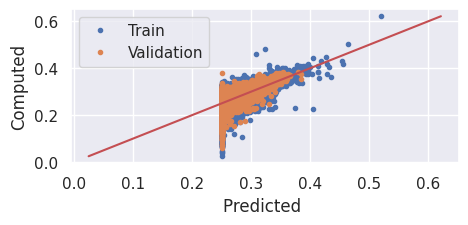

Epoch: 1, Train MAE: 0.0355, Val MAE: 0.0360
Epoch: 2, Train MAE: 0.0355, Val MAE: 0.0361
Epoch: 3, Train MAE: 0.0355, Val MAE: 0.0361
Epoch: 4, Train MAE: 0.0355, Val MAE: 0.0361
Epoch: 5, Train MAE: 0.0355, Val MAE: 0.0360


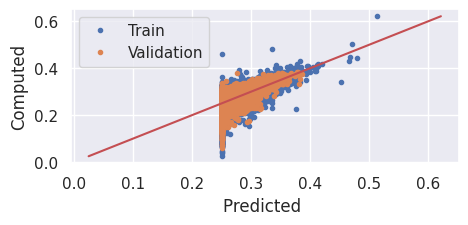

Epoch: 6, Train MAE: 0.0355, Val MAE: 0.0360
Epoch: 7, Train MAE: 0.0354, Val MAE: 0.0362
Epoch: 8, Train MAE: 0.0354, Val MAE: 0.0360
Epoch: 9, Train MAE: 0.0354, Val MAE: 0.0359
Epoch: 10, Train MAE: 0.0354, Val MAE: 0.0360


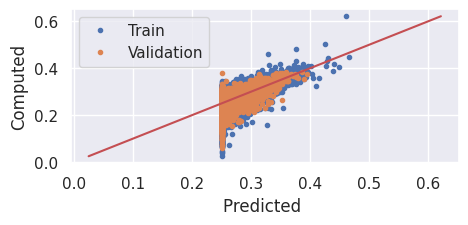

Epoch: 11, Train MAE: 0.0354, Val MAE: 0.0360
Epoch: 12, Train MAE: 0.0354, Val MAE: 0.0359
Epoch: 13, Train MAE: 0.0354, Val MAE: 0.0359
Epoch: 14, Train MAE: 0.0354, Val MAE: 0.0360
Epoch: 15, Train MAE: 0.0353, Val MAE: 0.0359


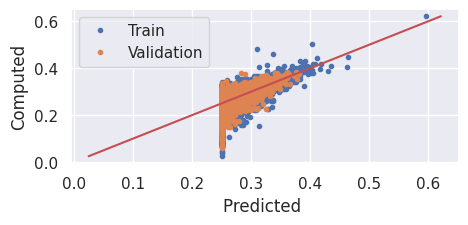

Epoch: 16, Train MAE: 0.0353, Val MAE: 0.0358
Epoch: 17, Train MAE: 0.0353, Val MAE: 0.0358
Epoch: 18, Train MAE: 0.0353, Val MAE: 0.0359
Epoch: 19, Train MAE: 0.0353, Val MAE: 0.0358
Epoch: 20, Train MAE: 0.0353, Val MAE: 0.0359


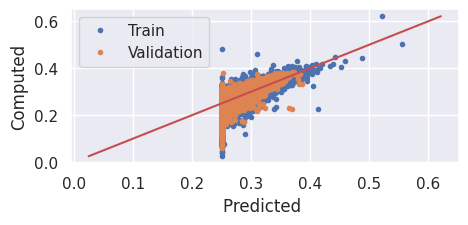

Epoch: 21, Train MAE: 0.0353, Val MAE: 0.0358
Epoch: 22, Train MAE: 0.0353, Val MAE: 0.0358
Epoch: 23, Train MAE: 0.0352, Val MAE: 0.0357
Epoch: 24, Train MAE: 0.0352, Val MAE: 0.0359
Epoch: 25, Train MAE: 0.0352, Val MAE: 0.0358


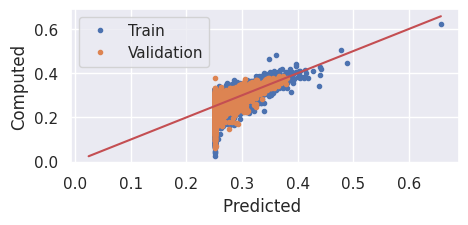

Epoch: 26, Train MAE: 0.0352, Val MAE: 0.0358
Epoch: 27, Train MAE: 0.0352, Val MAE: 0.0358
Epoch: 28, Train MAE: 0.0352, Val MAE: 0.0358
Epoch: 29, Train MAE: 0.0352, Val MAE: 0.0358
Epoch: 30, Train MAE: 0.0352, Val MAE: 0.0357


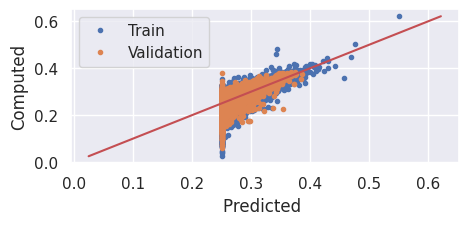

Epoch: 31, Train MAE: 0.0352, Val MAE: 0.0359
Epoch: 32, Train MAE: 0.0352, Val MAE: 0.0358
Epoch: 33, Train MAE: 0.0351, Val MAE: 0.0358
Epoch: 34, Train MAE: 0.0352, Val MAE: 0.0358
Epoch: 35, Train MAE: 0.0351, Val MAE: 0.0357


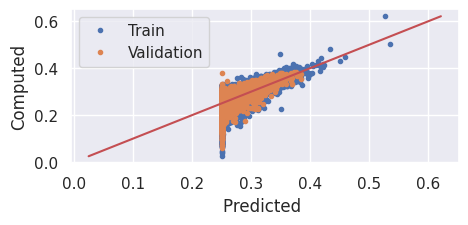

Epoch: 36, Train MAE: 0.0351, Val MAE: 0.0357
Epoch: 37, Train MAE: 0.0351, Val MAE: 0.0358
Epoch: 38, Train MAE: 0.0351, Val MAE: 0.0358
Epoch: 39, Train MAE: 0.0351, Val MAE: 0.0356
Epoch: 40, Train MAE: 0.0351, Val MAE: 0.0357


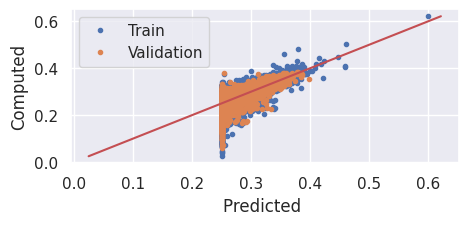

Epoch: 41, Train MAE: 0.0351, Val MAE: 0.0357
Epoch: 42, Train MAE: 0.0351, Val MAE: 0.0357
Epoch: 43, Train MAE: 0.0351, Val MAE: 0.0357
Epoch: 44, Train MAE: 0.0350, Val MAE: 0.0356
Epoch: 45, Train MAE: 0.0350, Val MAE: 0.0357


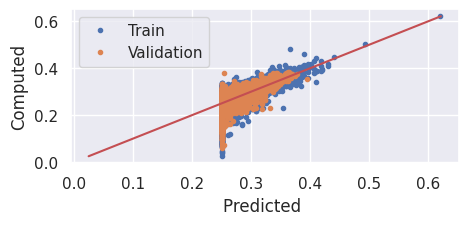

Epoch: 46, Train MAE: 0.0350, Val MAE: 0.0357
Epoch: 47, Train MAE: 0.0350, Val MAE: 0.0357
Epoch: 48, Train MAE: 0.0350, Val MAE: 0.0356
Epoch: 49, Train MAE: 0.0350, Val MAE: 0.0356
Epoch: 50, Train MAE: 0.0350, Val MAE: 0.0358


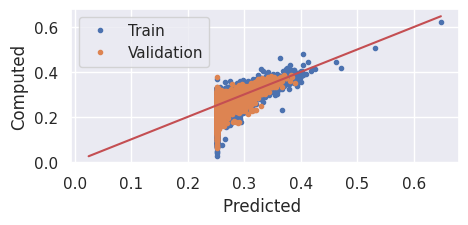

Epoch: 51, Train MAE: 0.0350, Val MAE: 0.0357
Epoch: 52, Train MAE: 0.0350, Val MAE: 0.0356
Epoch: 53, Train MAE: 0.0350, Val MAE: 0.0357
Epoch: 54, Train MAE: 0.0350, Val MAE: 0.0356
Epoch: 55, Train MAE: 0.0350, Val MAE: 0.0356


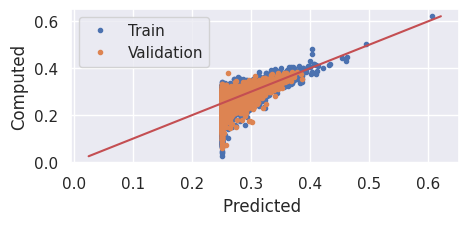

Epoch: 56, Train MAE: 0.0350, Val MAE: 0.0357
Epoch: 57, Train MAE: 0.0349, Val MAE: 0.0357
Epoch: 58, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 59, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 60, Train MAE: 0.0349, Val MAE: 0.0357


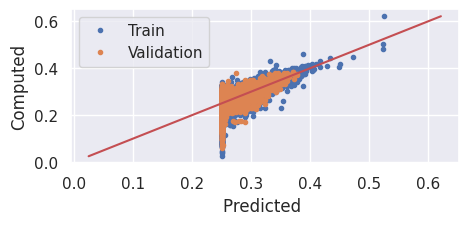

Epoch: 61, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 62, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 63, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 64, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 65, Train MAE: 0.0349, Val MAE: 0.0356


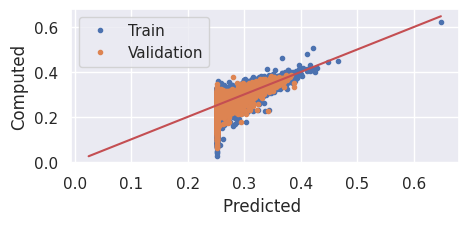

Epoch: 66, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 67, Train MAE: 0.0349, Val MAE: 0.0358
Epoch: 68, Train MAE: 0.0349, Val MAE: 0.0355
Epoch: 69, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 70, Train MAE: 0.0349, Val MAE: 0.0356


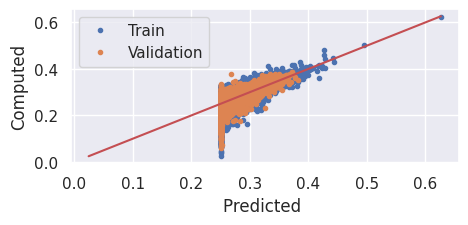

Epoch: 71, Train MAE: 0.0349, Val MAE: 0.0355
Epoch: 72, Train MAE: 0.0349, Val MAE: 0.0355
Epoch: 73, Train MAE: 0.0349, Val MAE: 0.0355
Epoch: 74, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 75, Train MAE: 0.0348, Val MAE: 0.0357


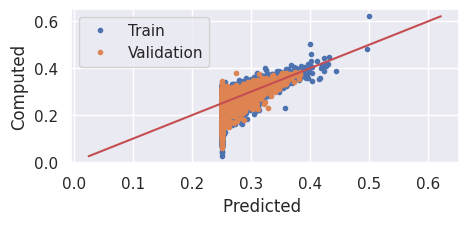

Epoch: 76, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 77, Train MAE: 0.0349, Val MAE: 0.0356
Epoch: 78, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 79, Train MAE: 0.0348, Val MAE: 0.0356
Epoch: 80, Train MAE: 0.0348, Val MAE: 0.0356


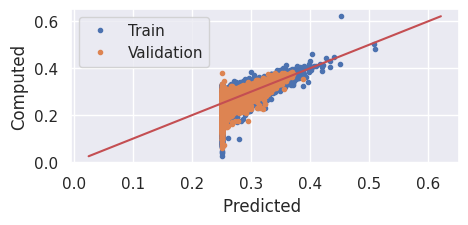

Epoch: 81, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 82, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 83, Train MAE: 0.0348, Val MAE: 0.0357
Epoch: 84, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 85, Train MAE: 0.0348, Val MAE: 0.0355


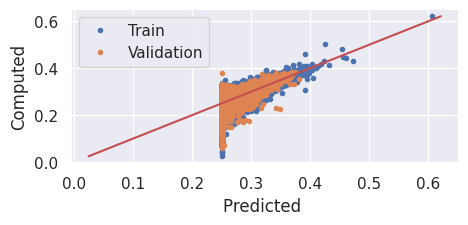

Epoch: 86, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 87, Train MAE: 0.0348, Val MAE: 0.0356
Epoch: 88, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 89, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 90, Train MAE: 0.0347, Val MAE: 0.0355


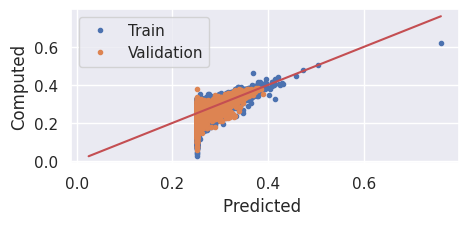

Epoch: 91, Train MAE: 0.0348, Val MAE: 0.0356
Epoch: 92, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 93, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 94, Train MAE: 0.0347, Val MAE: 0.0356
Epoch: 95, Train MAE: 0.0347, Val MAE: 0.0355


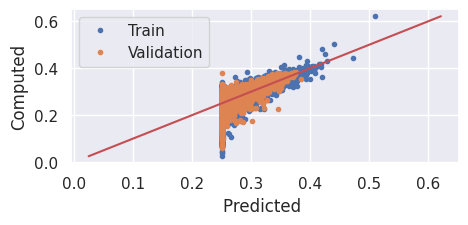

Epoch: 96, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 97, Train MAE: 0.0347, Val MAE: 0.0356
Epoch: 98, Train MAE: 0.0348, Val MAE: 0.0355
Epoch: 99, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 100, Train MAE: 0.0347, Val MAE: 0.0355


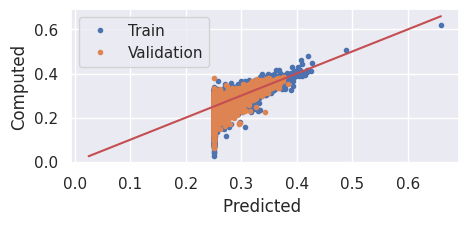

Epoch: 101, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 102, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 103, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 104, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 105, Train MAE: 0.0347, Val MAE: 0.0355


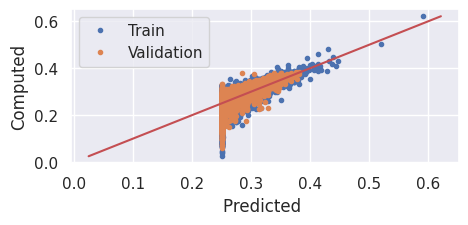

Epoch: 106, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 107, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 108, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 109, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 110, Train MAE: 0.0347, Val MAE: 0.0354


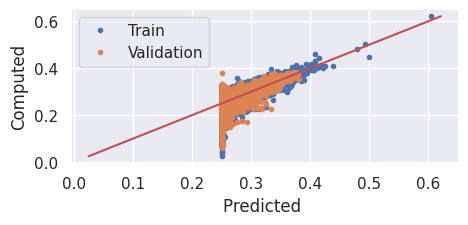

Epoch: 111, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 112, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 113, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 114, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 115, Train MAE: 0.0347, Val MAE: 0.0354


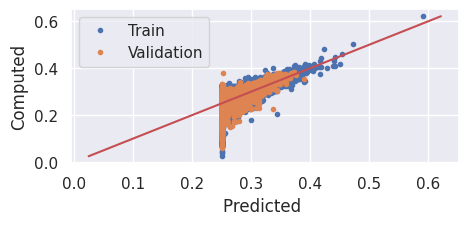

Epoch: 116, Train MAE: 0.0347, Val MAE: 0.0353
Epoch: 117, Train MAE: 0.0347, Val MAE: 0.0354
Epoch: 118, Train MAE: 0.0347, Val MAE: 0.0355
Epoch: 119, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 120, Train MAE: 0.0346, Val MAE: 0.0354


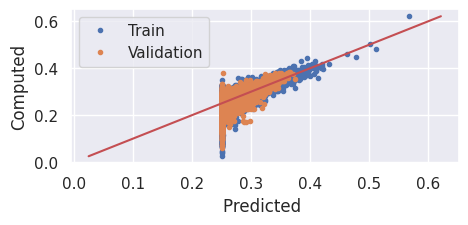

Epoch: 121, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 122, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 123, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 124, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 125, Train MAE: 0.0346, Val MAE: 0.0356


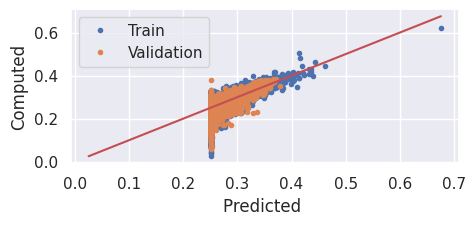

Epoch: 126, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 127, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 128, Train MAE: 0.0346, Val MAE: 0.0355
Epoch: 129, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 130, Train MAE: 0.0346, Val MAE: 0.0353


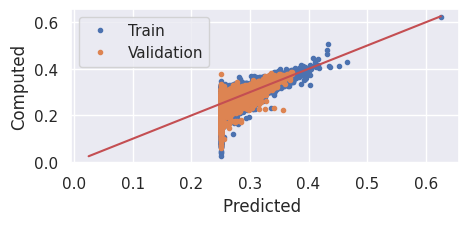

Epoch: 131, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 132, Train MAE: 0.0346, Val MAE: 0.0355
Epoch: 133, Train MAE: 0.0346, Val MAE: 0.0354
Epoch: 134, Train MAE: 0.0346, Val MAE: 0.0355
Epoch: 135, Train MAE: 0.0346, Val MAE: 0.0354


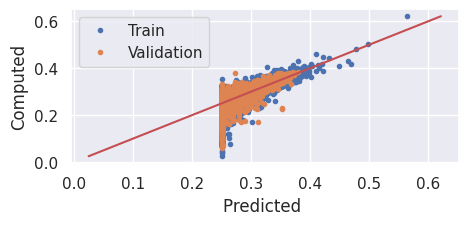

Epoch: 136, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 137, Train MAE: 0.0346, Val MAE: 0.0355
Epoch: 138, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 139, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 140, Train MAE: 0.0346, Val MAE: 0.0353


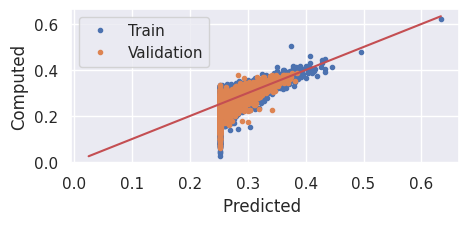

Epoch: 141, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 142, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 143, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 144, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 145, Train MAE: 0.0346, Val MAE: 0.0354


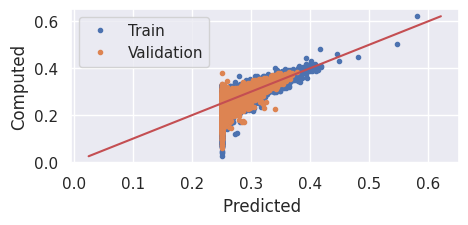

Epoch: 146, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 147, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 148, Train MAE: 0.0346, Val MAE: 0.0353
Epoch: 149, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 150, Train MAE: 0.0345, Val MAE: 0.0353


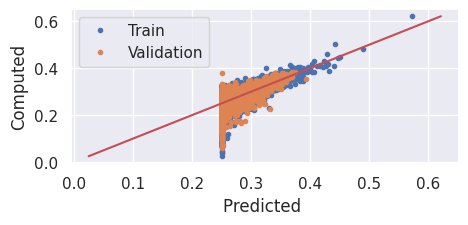

Epoch: 151, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 152, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 153, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 154, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 155, Train MAE: 0.0345, Val MAE: 0.0353


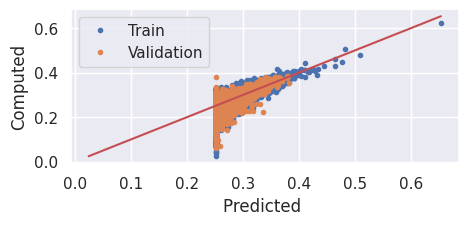

Epoch: 156, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 157, Train MAE: 0.0345, Val MAE: 0.0355
Epoch: 158, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 159, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 160, Train MAE: 0.0345, Val MAE: 0.0353


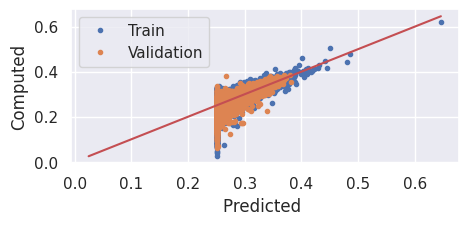

Epoch: 161, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 162, Train MAE: 0.0345, Val MAE: 0.0355
Epoch: 163, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 164, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 165, Train MAE: 0.0345, Val MAE: 0.0354


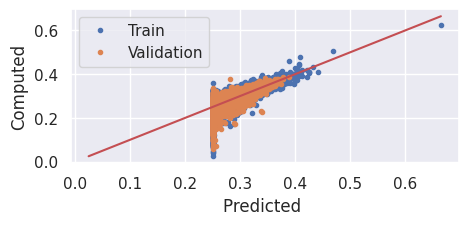

Epoch: 166, Train MAE: 0.0345, Val MAE: 0.0352
Epoch: 167, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 168, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 169, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 170, Train MAE: 0.0345, Val MAE: 0.0353


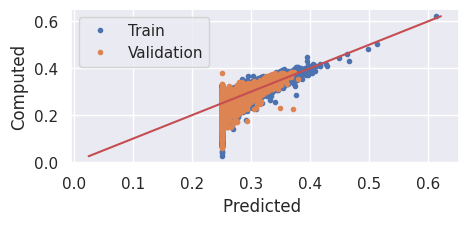

Epoch: 171, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 172, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 173, Train MAE: 0.0345, Val MAE: 0.0352
Epoch: 174, Train MAE: 0.0345, Val MAE: 0.0352
Epoch: 175, Train MAE: 0.0345, Val MAE: 0.0353


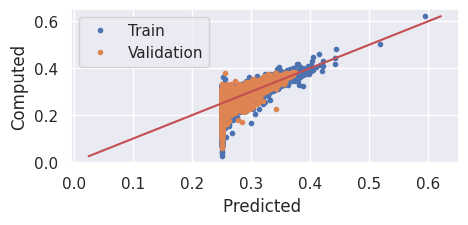

Epoch: 176, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 177, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 178, Train MAE: 0.0345, Val MAE: 0.0354
Epoch: 179, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 180, Train MAE: 0.0345, Val MAE: 0.0353


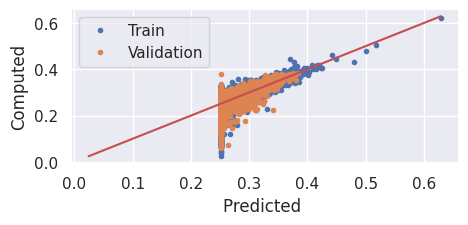

Epoch: 181, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 182, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 183, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 184, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 185, Train MAE: 0.0344, Val MAE: 0.0353


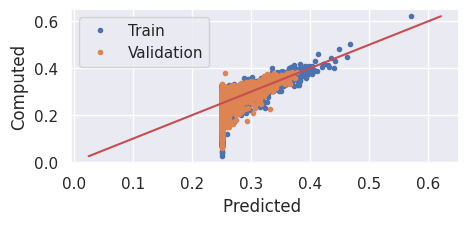

Epoch: 186, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 187, Train MAE: 0.0345, Val MAE: 0.0353
Epoch: 188, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 189, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 190, Train MAE: 0.0344, Val MAE: 0.0353


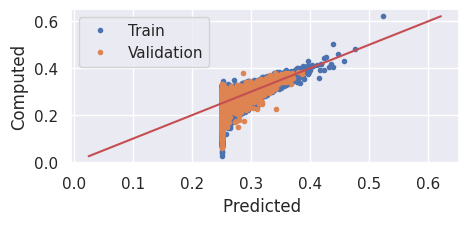

Epoch: 191, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 192, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 193, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 194, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 195, Train MAE: 0.0344, Val MAE: 0.0352


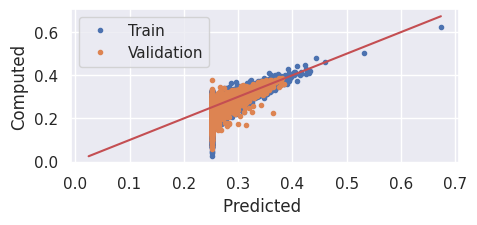

Epoch: 196, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 197, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 198, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 199, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 200, Train MAE: 0.0344, Val MAE: 0.0353


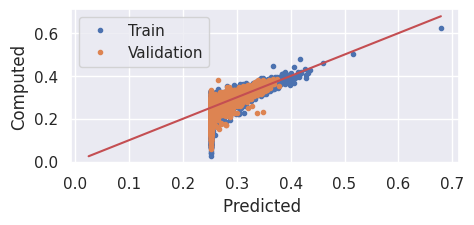

Epoch: 201, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 202, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 203, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 204, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 205, Train MAE: 0.0344, Val MAE: 0.0353


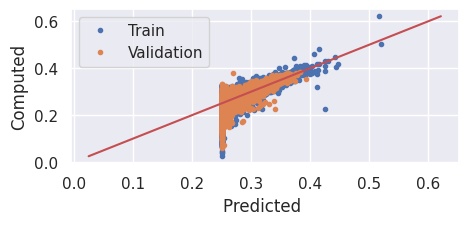

Epoch: 206, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 207, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 208, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 209, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 210, Train MAE: 0.0344, Val MAE: 0.0352


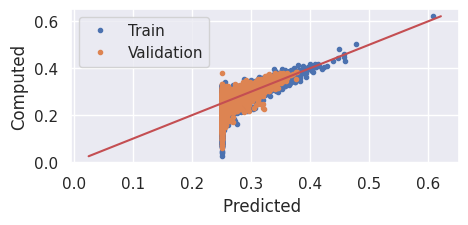

Epoch: 211, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 212, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 213, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 214, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 215, Train MAE: 0.0344, Val MAE: 0.0352


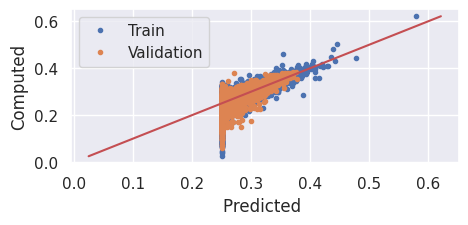

Epoch: 216, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 217, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 218, Train MAE: 0.0344, Val MAE: 0.0354
Epoch: 219, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 220, Train MAE: 0.0344, Val MAE: 0.0353


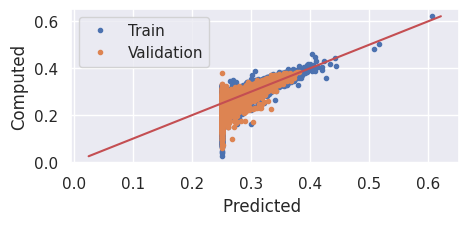

Epoch: 221, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 222, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 223, Train MAE: 0.0344, Val MAE: 0.0352
Epoch: 224, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 225, Train MAE: 0.0343, Val MAE: 0.0353


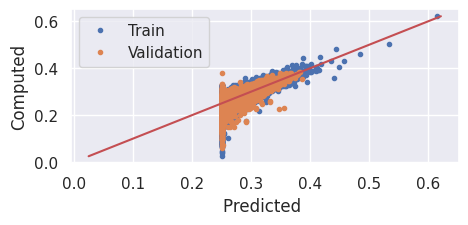

Epoch: 226, Train MAE: 0.0344, Val MAE: 0.0353
Epoch: 227, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 228, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 229, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 230, Train MAE: 0.0343, Val MAE: 0.0353


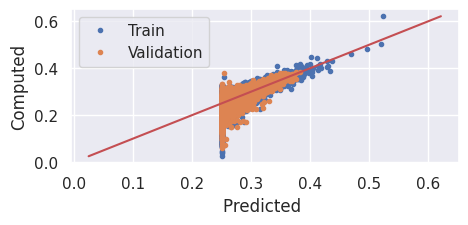

Epoch: 231, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 232, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 233, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 234, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 235, Train MAE: 0.0343, Val MAE: 0.0352


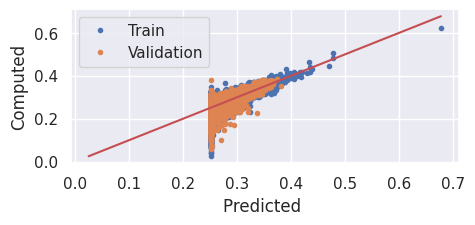

Epoch: 236, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 237, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 238, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 239, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 240, Train MAE: 0.0343, Val MAE: 0.0353


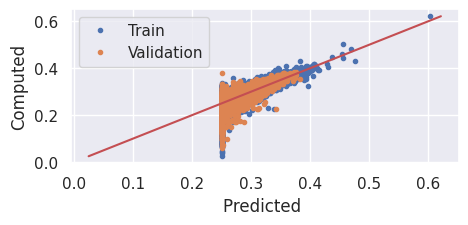

Epoch: 241, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 242, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 243, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 244, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 245, Train MAE: 0.0343, Val MAE: 0.0352


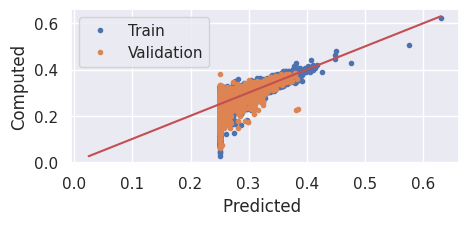

Epoch: 246, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 247, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 248, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 249, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 250, Train MAE: 0.0343, Val MAE: 0.0352


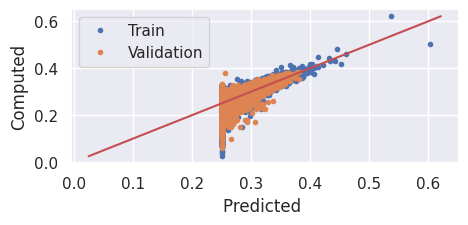

Epoch: 251, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 252, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 253, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 254, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 255, Train MAE: 0.0343, Val MAE: 0.0352


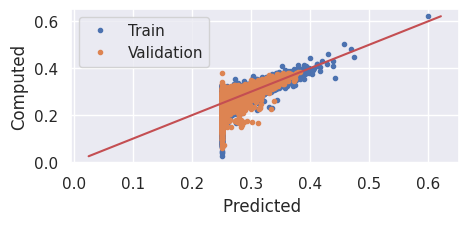

Epoch: 256, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 257, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 258, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 259, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 260, Train MAE: 0.0343, Val MAE: 0.0353


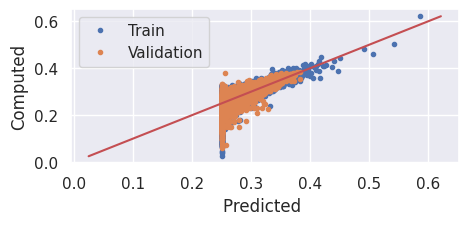

Epoch: 261, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 262, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 263, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 264, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 265, Train MAE: 0.0343, Val MAE: 0.0353


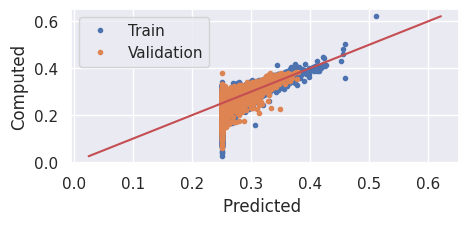

Epoch: 266, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 267, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 268, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 269, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 270, Train MAE: 0.0343, Val MAE: 0.0352


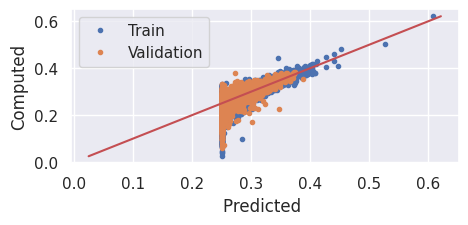

Epoch: 271, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 272, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 273, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 274, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 275, Train MAE: 0.0343, Val MAE: 0.0353


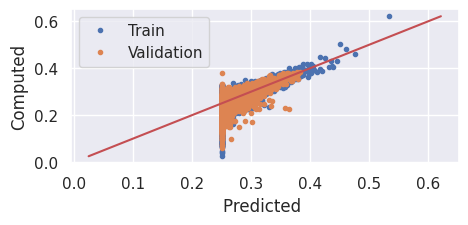

Epoch: 276, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 277, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 278, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 279, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 280, Train MAE: 0.0343, Val MAE: 0.0352


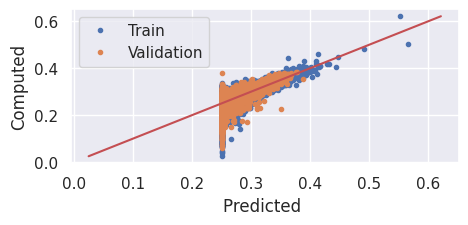

Epoch: 281, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 282, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 283, Train MAE: 0.0343, Val MAE: 0.0353
Epoch: 284, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 285, Train MAE: 0.0343, Val MAE: 0.0351


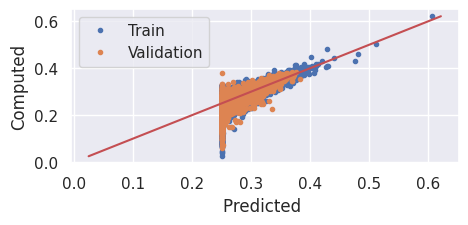

Epoch: 286, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 287, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 288, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 289, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 290, Train MAE: 0.0342, Val MAE: 0.0353


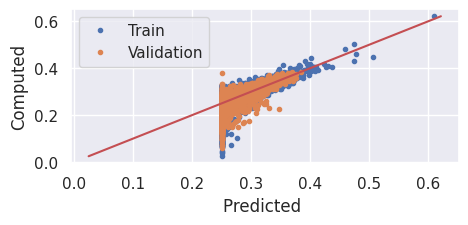

Epoch: 291, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 292, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 293, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 294, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 295, Train MAE: 0.0343, Val MAE: 0.0352


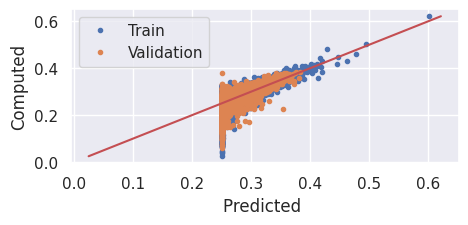

Epoch: 296, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 297, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 298, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 299, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 300, Train MAE: 0.0342, Val MAE: 0.0352


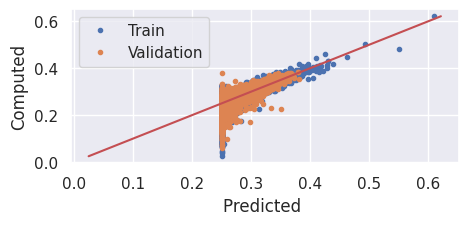

Epoch: 301, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 302, Train MAE: 0.0343, Val MAE: 0.0352
Epoch: 303, Train MAE: 0.0342, Val MAE: 0.0353
Epoch: 304, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 305, Train MAE: 0.0342, Val MAE: 0.0352


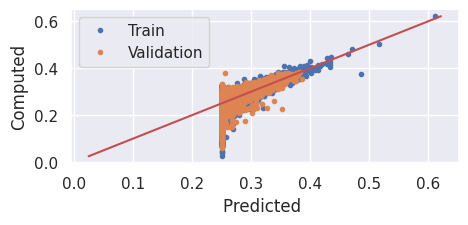

Epoch: 306, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 307, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 308, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 309, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 310, Train MAE: 0.0342, Val MAE: 0.0353


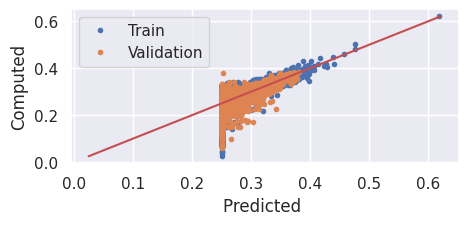

Epoch: 311, Train MAE: 0.0342, Val MAE: 0.0353
Epoch: 312, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 313, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 314, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 315, Train MAE: 0.0342, Val MAE: 0.0352


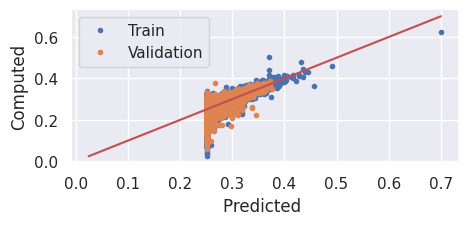

Epoch: 316, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 317, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 318, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 319, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 320, Train MAE: 0.0342, Val MAE: 0.0353


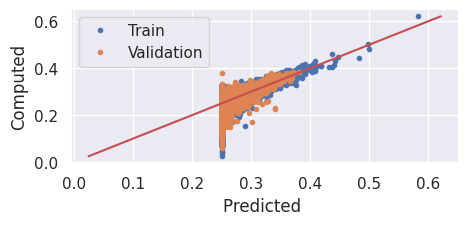

Epoch: 321, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 322, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 323, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 324, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 325, Train MAE: 0.0342, Val MAE: 0.0352


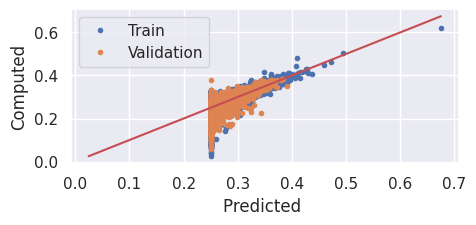

Epoch: 326, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 327, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 328, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 329, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 330, Train MAE: 0.0342, Val MAE: 0.0352


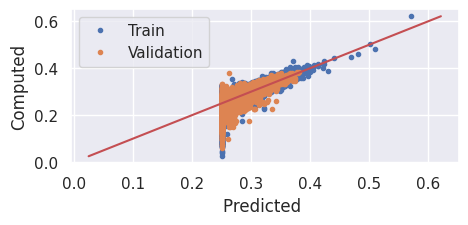

Epoch: 331, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 332, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 333, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 334, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 335, Train MAE: 0.0342, Val MAE: 0.0352


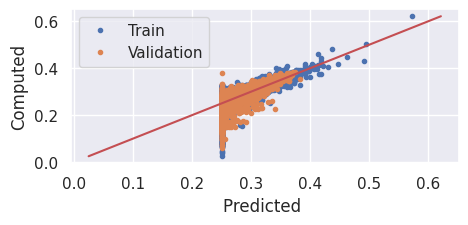

Epoch: 336, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 337, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 338, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 339, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 340, Train MAE: 0.0342, Val MAE: 0.0352


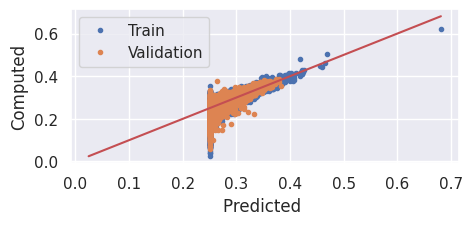

Epoch: 341, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 342, Train MAE: 0.0342, Val MAE: 0.0353
Epoch: 343, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 344, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 345, Train MAE: 0.0342, Val MAE: 0.0352


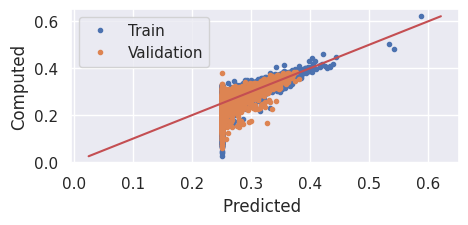

Epoch: 346, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 347, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 348, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 349, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 350, Train MAE: 0.0342, Val MAE: 0.0351


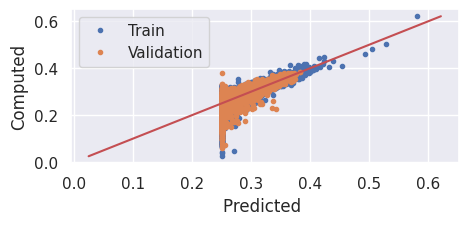

Epoch: 351, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 352, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 353, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 354, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 355, Train MAE: 0.0342, Val MAE: 0.0352


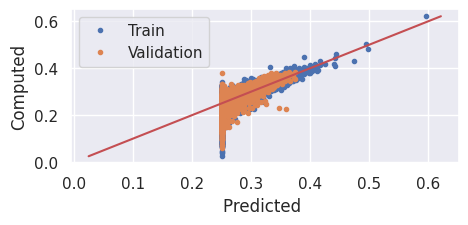

Epoch: 356, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 357, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 358, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 359, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 360, Train MAE: 0.0342, Val MAE: 0.0351


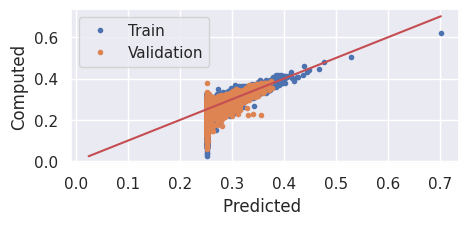

Epoch: 361, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 362, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 363, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 364, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 365, Train MAE: 0.0342, Val MAE: 0.0352


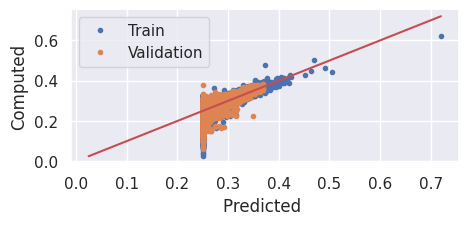

Epoch: 366, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 367, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 368, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 369, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 370, Train MAE: 0.0342, Val MAE: 0.0351


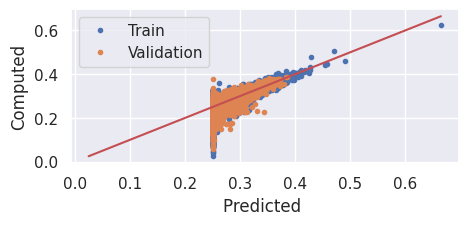

Epoch: 371, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 372, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 373, Train MAE: 0.0342, Val MAE: 0.0353
Epoch: 374, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 375, Train MAE: 0.0342, Val MAE: 0.0352


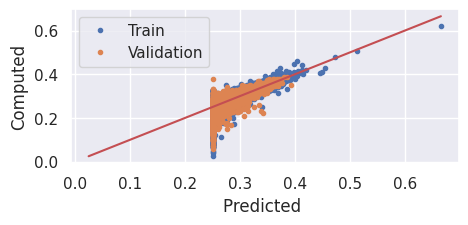

Epoch: 376, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 377, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 378, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 379, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 380, Train MAE: 0.0342, Val MAE: 0.0352


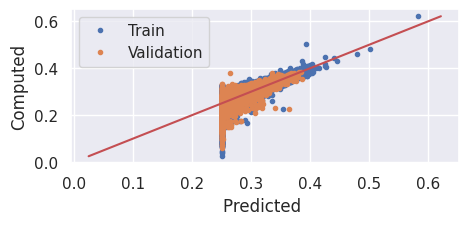

Epoch: 381, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 382, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 383, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 384, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 385, Train MAE: 0.0342, Val MAE: 0.0352


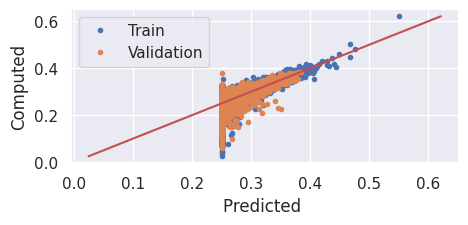

Epoch: 386, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 387, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 388, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 389, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 390, Train MAE: 0.0342, Val MAE: 0.0352


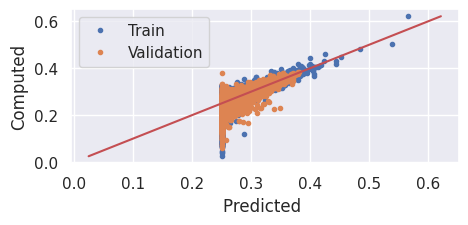

Epoch: 391, Train MAE: 0.0341, Val MAE: 0.0353
Epoch: 392, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 393, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 394, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 395, Train MAE: 0.0341, Val MAE: 0.0352


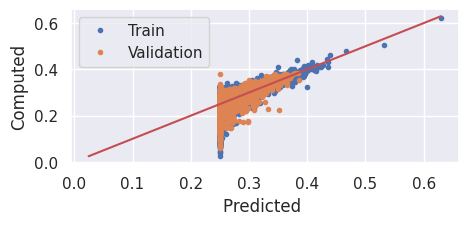

Epoch: 396, Train MAE: 0.0342, Val MAE: 0.0352
Epoch: 397, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 398, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 399, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 400, Train MAE: 0.0341, Val MAE: 0.0352


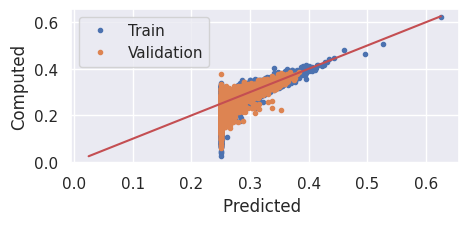

Epoch: 401, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 402, Train MAE: 0.0342, Val MAE: 0.0351
Epoch: 403, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 404, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 405, Train MAE: 0.0341, Val MAE: 0.0352


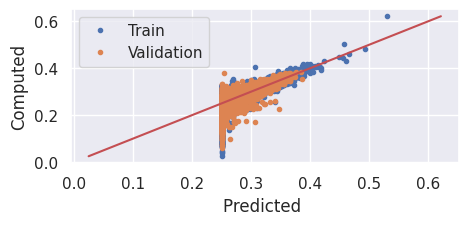

Epoch: 406, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 407, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 408, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 409, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 410, Train MAE: 0.0341, Val MAE: 0.0352


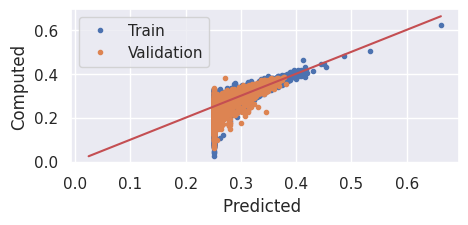

Epoch: 411, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 412, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 413, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 414, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 415, Train MAE: 0.0341, Val MAE: 0.0352


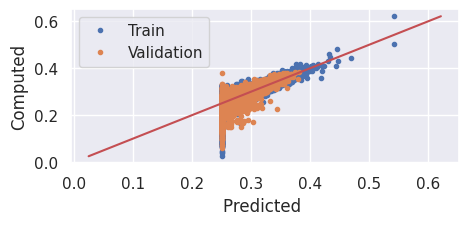

Epoch: 416, Train MAE: 0.0341, Val MAE: 0.0353
Epoch: 417, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 418, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 419, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 420, Train MAE: 0.0341, Val MAE: 0.0352


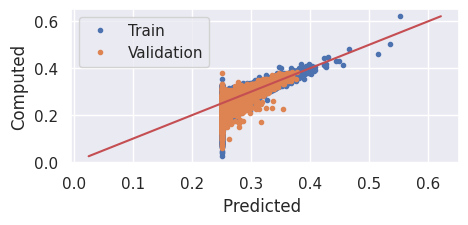

Epoch: 421, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 422, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 423, Train MAE: 0.0341, Val MAE: 0.0353
Epoch: 424, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 425, Train MAE: 0.0341, Val MAE: 0.0351


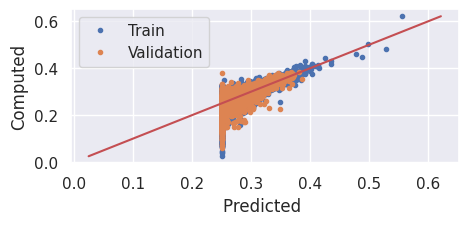

Epoch: 426, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 427, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 428, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 429, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 430, Train MAE: 0.0341, Val MAE: 0.0351


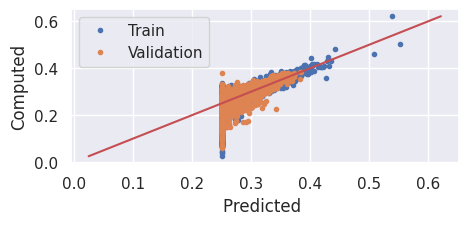

Epoch: 431, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 432, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 433, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 434, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 435, Train MAE: 0.0341, Val MAE: 0.0351


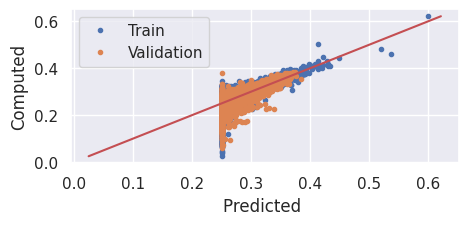

Epoch: 436, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 437, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 438, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 439, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 440, Train MAE: 0.0341, Val MAE: 0.0351


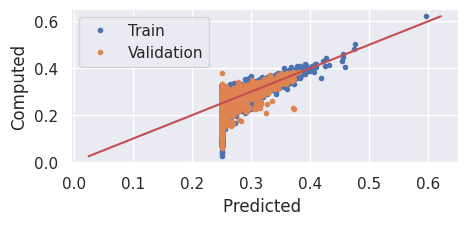

Epoch: 441, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 442, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 443, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 444, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 445, Train MAE: 0.0341, Val MAE: 0.0352


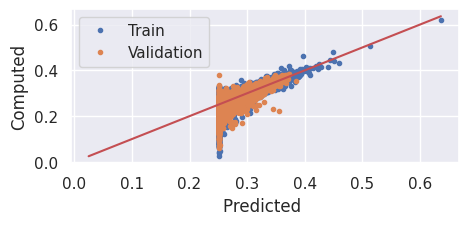

Epoch: 446, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 447, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 448, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 449, Train MAE: 0.0341, Val MAE: 0.0353
Epoch: 450, Train MAE: 0.0341, Val MAE: 0.0351


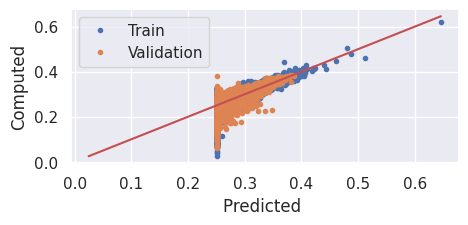

Epoch: 451, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 452, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 453, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 454, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 455, Train MAE: 0.0341, Val MAE: 0.0351


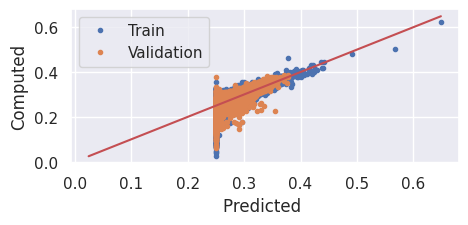

Epoch: 456, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 457, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 458, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 459, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 460, Train MAE: 0.0341, Val MAE: 0.0352


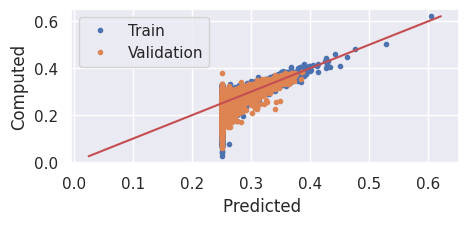

Epoch: 461, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 462, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 463, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 464, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 465, Train MAE: 0.0341, Val MAE: 0.0351


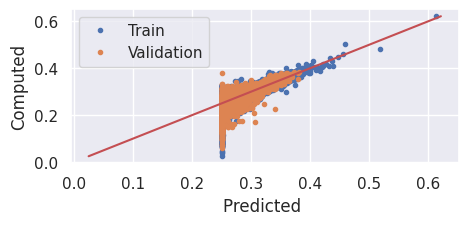

Epoch: 466, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 467, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 468, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 469, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 470, Train MAE: 0.0341, Val MAE: 0.0352


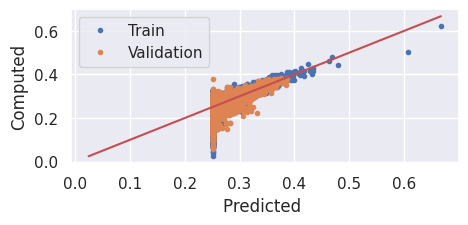

Epoch: 471, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 472, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 473, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 474, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 475, Train MAE: 0.0341, Val MAE: 0.0352


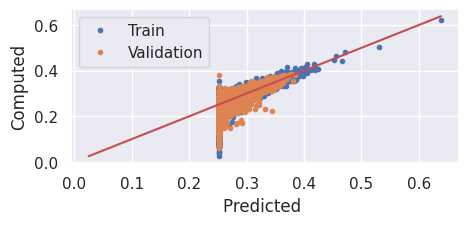

Epoch: 476, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 477, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 478, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 479, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 480, Train MAE: 0.0341, Val MAE: 0.0351


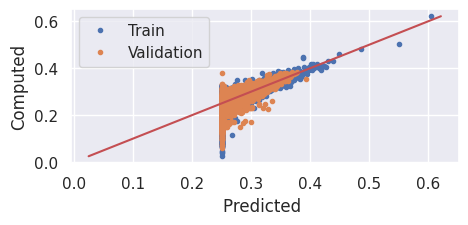

Epoch: 481, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 482, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 483, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 484, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 485, Train MAE: 0.0341, Val MAE: 0.0351


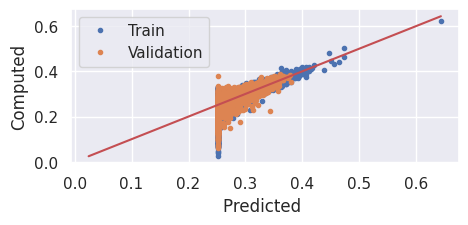

Epoch: 486, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 487, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 488, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 489, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 490, Train MAE: 0.0341, Val MAE: 0.0352


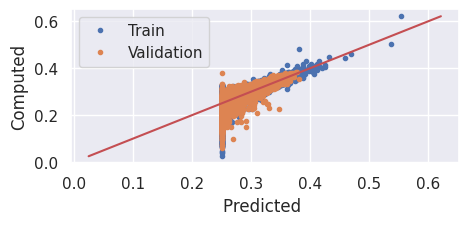

Epoch: 491, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 492, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 493, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 494, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 495, Train MAE: 0.0341, Val MAE: 0.0351


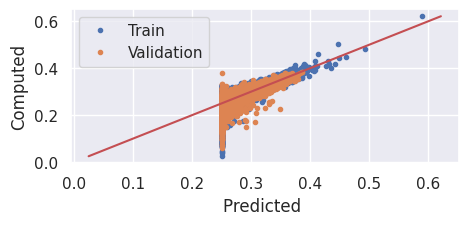

Epoch: 496, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 497, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 498, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 499, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 500, Train MAE: 0.0341, Val MAE: 0.0351


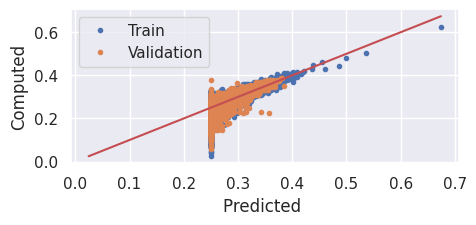

Epoch: 501, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 502, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 503, Train MAE: 0.0341, Val MAE: 0.0353
Epoch: 504, Train MAE: 0.0341, Val MAE: 0.0353
Epoch: 505, Train MAE: 0.0341, Val MAE: 0.0352


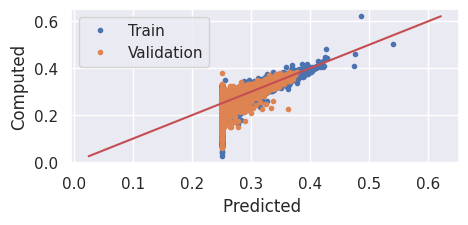

Epoch: 506, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 507, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 508, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 509, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 510, Train MAE: 0.0341, Val MAE: 0.0351


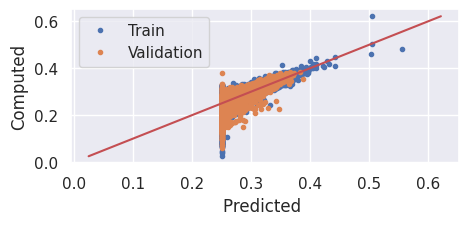

Epoch: 511, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 512, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 513, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 514, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 515, Train MAE: 0.0341, Val MAE: 0.0351


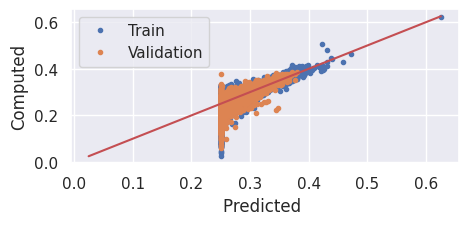

Epoch: 516, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 517, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 518, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 519, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 520, Train MAE: 0.0341, Val MAE: 0.0351


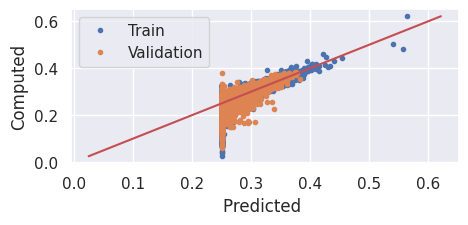

Epoch: 521, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 522, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 523, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 524, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 525, Train MAE: 0.0341, Val MAE: 0.0352


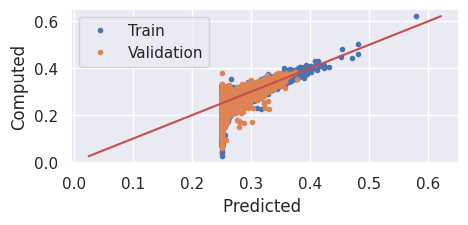

Epoch: 526, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 527, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 528, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 529, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 530, Train MAE: 0.0340, Val MAE: 0.0351


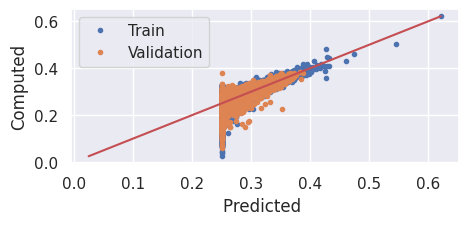

Epoch: 531, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 532, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 533, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 534, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 535, Train MAE: 0.0340, Val MAE: 0.0351


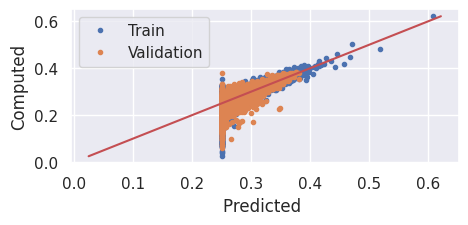

Epoch: 536, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 537, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 538, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 539, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 540, Train MAE: 0.0340, Val MAE: 0.0352


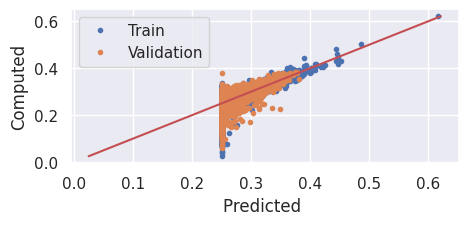

Epoch: 541, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 542, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 543, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 544, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 545, Train MAE: 0.0340, Val MAE: 0.0351


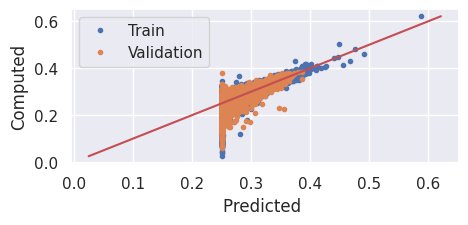

Epoch: 546, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 547, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 548, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 549, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 550, Train MAE: 0.0341, Val MAE: 0.0351


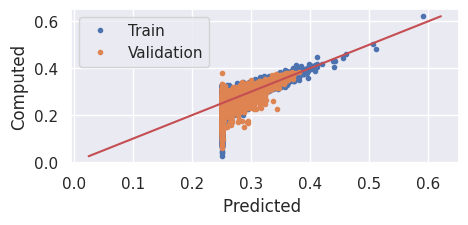

Epoch: 551, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 552, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 553, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 554, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 555, Train MAE: 0.0340, Val MAE: 0.0351


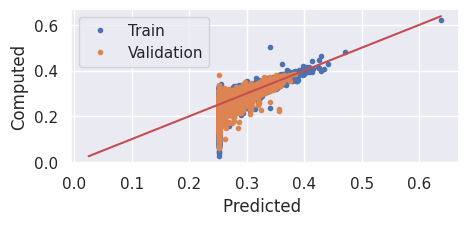

Epoch: 556, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 557, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 558, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 559, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 560, Train MAE: 0.0340, Val MAE: 0.0351


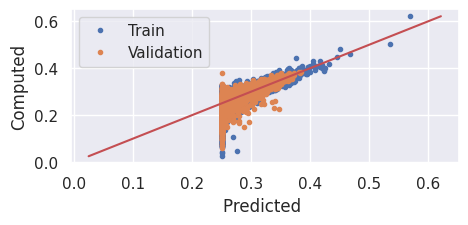

Epoch: 561, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 562, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 563, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 564, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 565, Train MAE: 0.0340, Val MAE: 0.0352


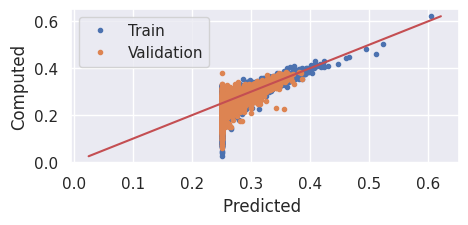

Epoch: 566, Train MAE: 0.0341, Val MAE: 0.0351
Epoch: 567, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 568, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 569, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 570, Train MAE: 0.0340, Val MAE: 0.0351


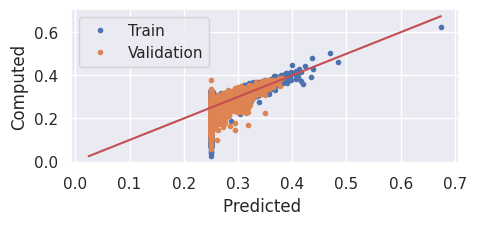

Epoch: 571, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 572, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 573, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 574, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 575, Train MAE: 0.0340, Val MAE: 0.0352


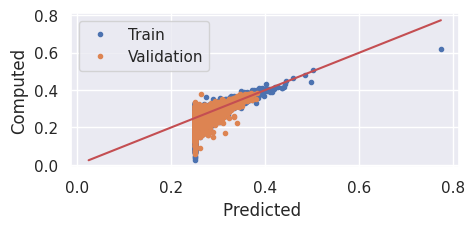

Epoch: 576, Train MAE: 0.0341, Val MAE: 0.0352
Epoch: 577, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 578, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 579, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 580, Train MAE: 0.0340, Val MAE: 0.0351


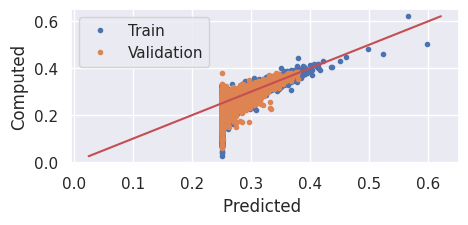

Epoch: 581, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 582, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 583, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 584, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 585, Train MAE: 0.0340, Val MAE: 0.0351


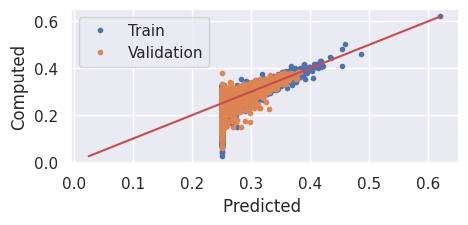

Epoch: 586, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 587, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 588, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 589, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 590, Train MAE: 0.0340, Val MAE: 0.0351


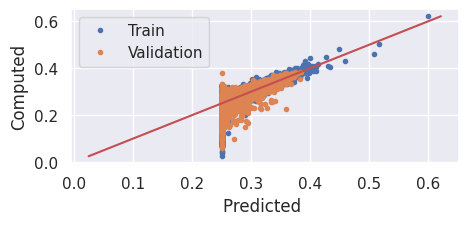

Epoch: 591, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 592, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 593, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 594, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 595, Train MAE: 0.0340, Val MAE: 0.0352


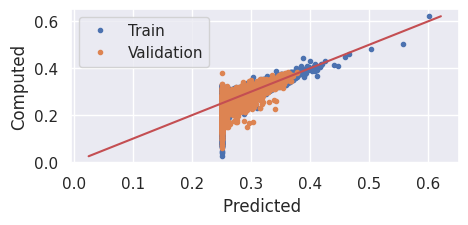

Epoch: 596, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 597, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 598, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 599, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 600, Train MAE: 0.0340, Val MAE: 0.0351


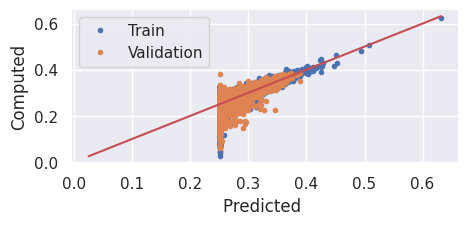

Epoch: 601, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 602, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 603, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 604, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 605, Train MAE: 0.0340, Val MAE: 0.0351


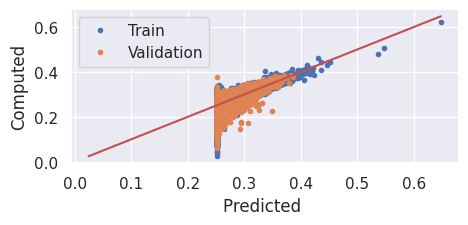

Epoch: 606, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 607, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 608, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 609, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 610, Train MAE: 0.0340, Val MAE: 0.0351


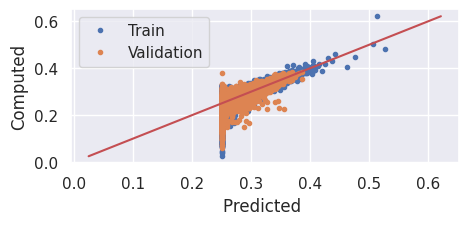

Epoch: 611, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 612, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 613, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 614, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 615, Train MAE: 0.0340, Val MAE: 0.0352


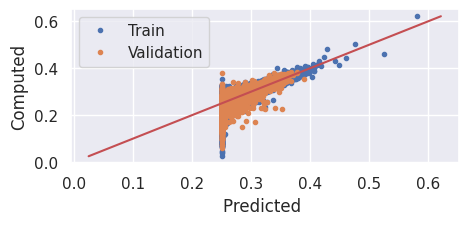

Epoch: 616, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 617, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 618, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 619, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 620, Train MAE: 0.0340, Val MAE: 0.0351


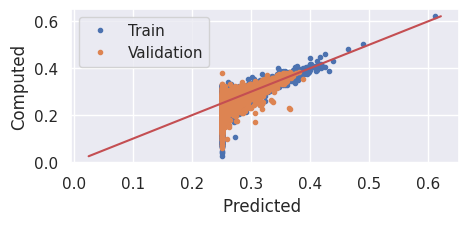

Epoch: 621, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 622, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 623, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 624, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 625, Train MAE: 0.0340, Val MAE: 0.0351


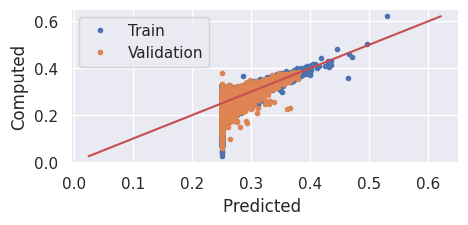

Epoch: 626, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 627, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 628, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 629, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 630, Train MAE: 0.0340, Val MAE: 0.0351


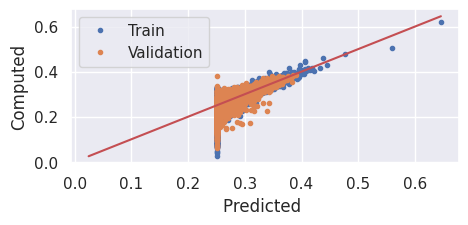

Epoch: 631, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 632, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 633, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 634, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 635, Train MAE: 0.0340, Val MAE: 0.0352


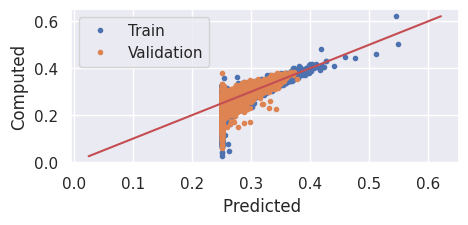

Epoch: 636, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 637, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 638, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 639, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 640, Train MAE: 0.0340, Val MAE: 0.0351


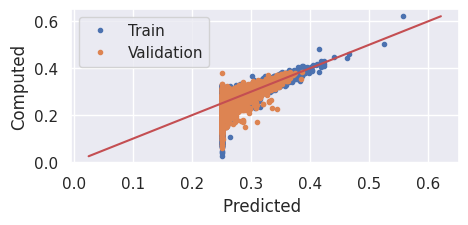

Epoch: 641, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 642, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 643, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 644, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 645, Train MAE: 0.0340, Val MAE: 0.0351


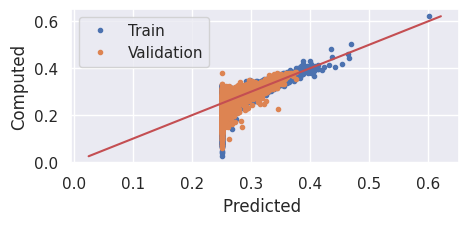

Epoch: 646, Train MAE: 0.0340, Val MAE: 0.0350
Epoch: 647, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 648, Train MAE: 0.0340, Val MAE: 0.0350
Epoch: 649, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 650, Train MAE: 0.0340, Val MAE: 0.0351


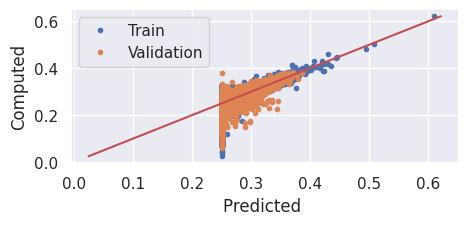

Epoch: 651, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 652, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 653, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 654, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 655, Train MAE: 0.0340, Val MAE: 0.0351


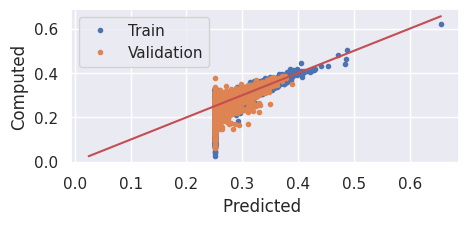

Epoch: 656, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 657, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 658, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 659, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 660, Train MAE: 0.0340, Val MAE: 0.0351


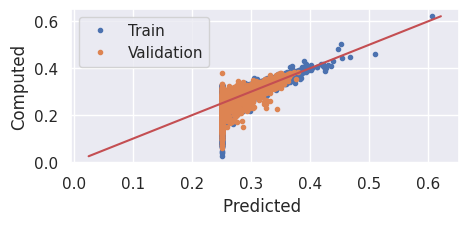

Epoch: 661, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 662, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 663, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 664, Train MAE: 0.0340, Val MAE: 0.0350
Epoch: 665, Train MAE: 0.0340, Val MAE: 0.0352


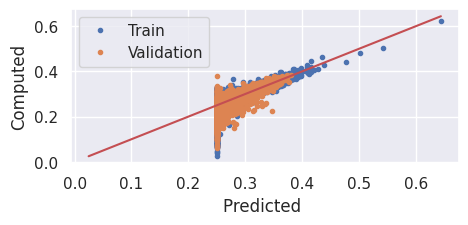

Epoch: 666, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 667, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 668, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 669, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 670, Train MAE: 0.0340, Val MAE: 0.0352


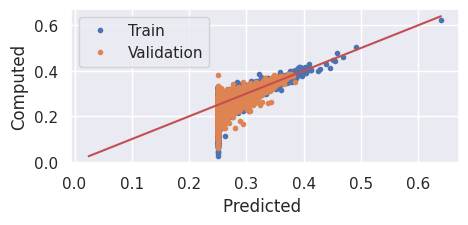

Epoch: 671, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 672, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 673, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 674, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 675, Train MAE: 0.0340, Val MAE: 0.0351


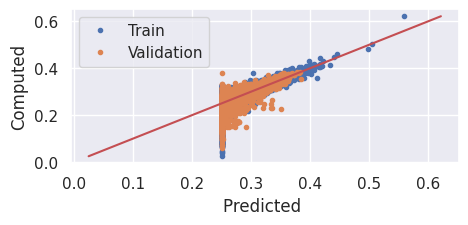

Epoch: 676, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 677, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 678, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 679, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 680, Train MAE: 0.0340, Val MAE: 0.0350


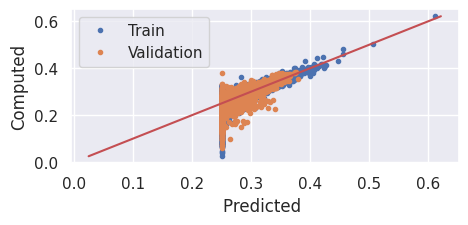

Epoch: 681, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 682, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 683, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 684, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 685, Train MAE: 0.0340, Val MAE: 0.0351


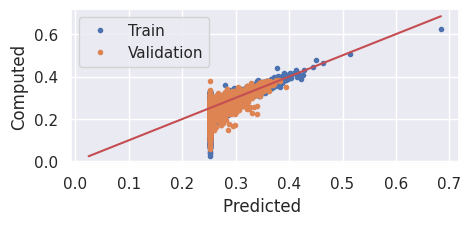

Epoch: 686, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 687, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 688, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 689, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 690, Train MAE: 0.0340, Val MAE: 0.0352


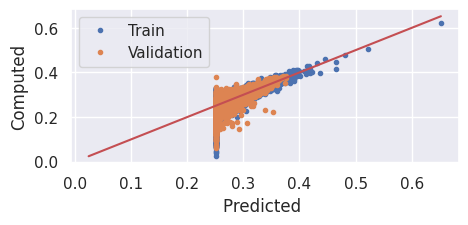

Epoch: 691, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 692, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 693, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 694, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 695, Train MAE: 0.0340, Val MAE: 0.0350


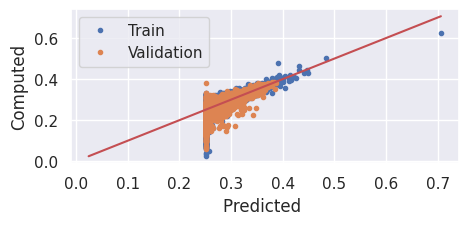

Epoch: 696, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 697, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 698, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 699, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 700, Train MAE: 0.0340, Val MAE: 0.0351


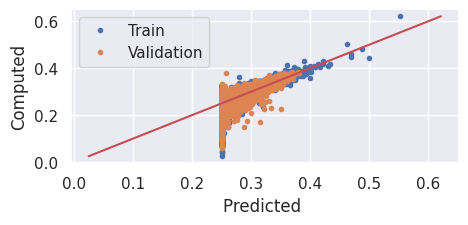

Epoch: 701, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 702, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 703, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 704, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 705, Train MAE: 0.0340, Val MAE: 0.0351


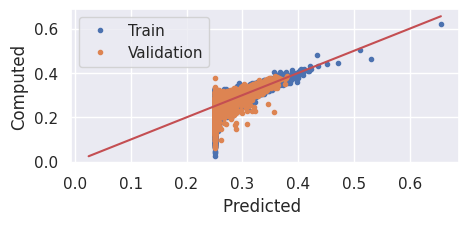

Epoch: 706, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 707, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 708, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 709, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 710, Train MAE: 0.0340, Val MAE: 0.0351


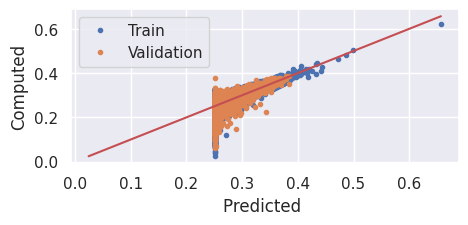

Epoch: 711, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 712, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 713, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 714, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 715, Train MAE: 0.0340, Val MAE: 0.0351


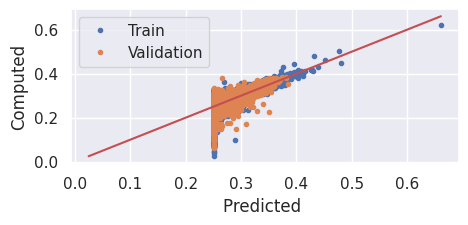

Epoch: 716, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 717, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 718, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 719, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 720, Train MAE: 0.0340, Val MAE: 0.0351


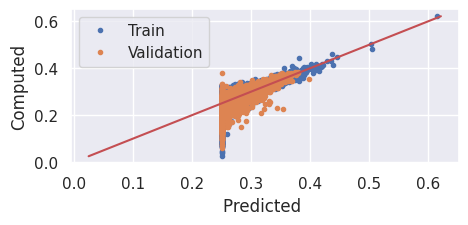

Epoch: 721, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 722, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 723, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 724, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 725, Train MAE: 0.0340, Val MAE: 0.0351


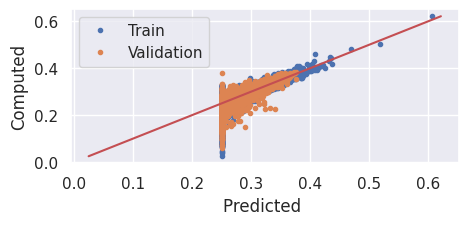

Epoch: 726, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 727, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 728, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 729, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 730, Train MAE: 0.0340, Val MAE: 0.0351


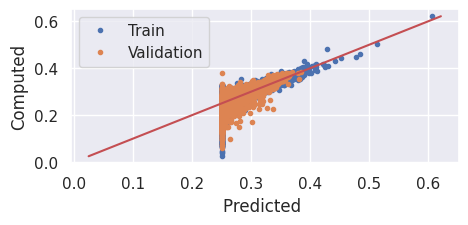

Epoch: 731, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 732, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 733, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 734, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 735, Train MAE: 0.0340, Val MAE: 0.0352


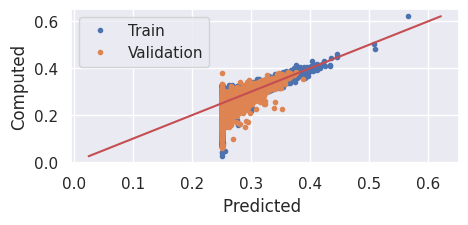

Epoch: 736, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 737, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 738, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 739, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 740, Train MAE: 0.0340, Val MAE: 0.0352


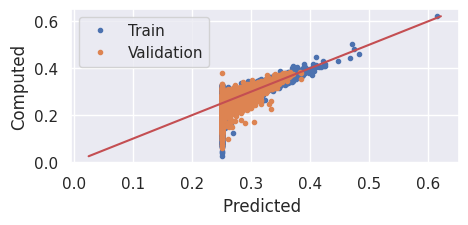

Epoch: 741, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 742, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 743, Train MAE: 0.0340, Val MAE: 0.0350
Epoch: 744, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 745, Train MAE: 0.0340, Val MAE: 0.0352


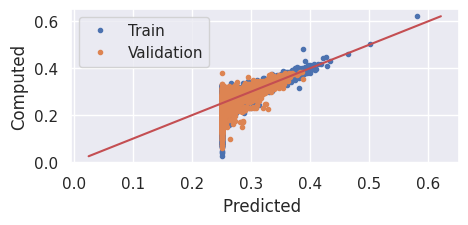

Epoch: 746, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 747, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 748, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 749, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 750, Train MAE: 0.0340, Val MAE: 0.0352


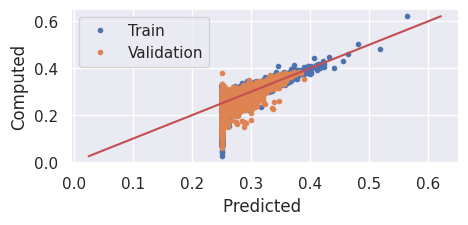

Epoch: 751, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 752, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 753, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 754, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 755, Train MAE: 0.0340, Val MAE: 0.0351


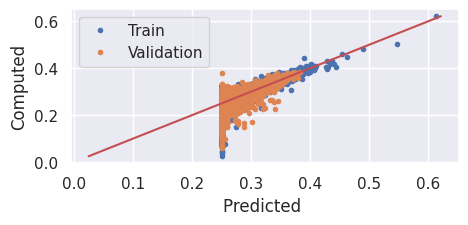

Epoch: 756, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 757, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 758, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 759, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 760, Train MAE: 0.0339, Val MAE: 0.0351


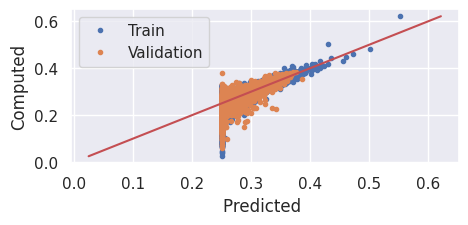

Epoch: 761, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 762, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 763, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 764, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 765, Train MAE: 0.0340, Val MAE: 0.0351


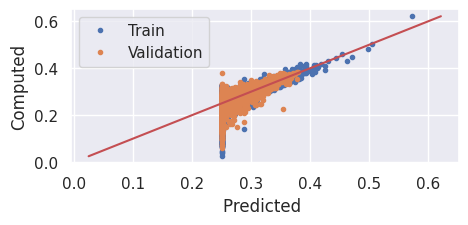

Epoch: 766, Train MAE: 0.0340, Val MAE: 0.0350
Epoch: 767, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 768, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 769, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 770, Train MAE: 0.0339, Val MAE: 0.0351


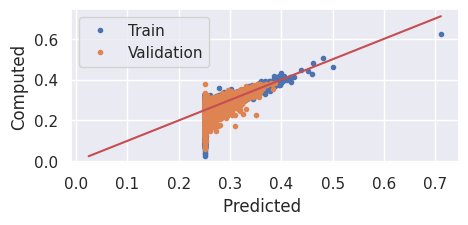

Epoch: 771, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 772, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 773, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 774, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 775, Train MAE: 0.0339, Val MAE: 0.0351


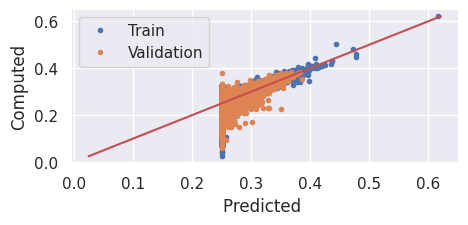

Epoch: 776, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 777, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 778, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 779, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 780, Train MAE: 0.0339, Val MAE: 0.0352


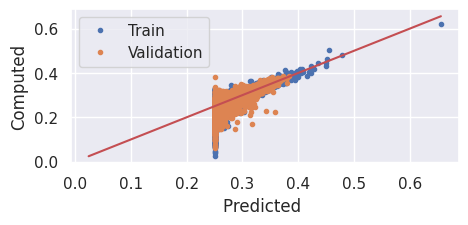

Epoch: 781, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 782, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 783, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 784, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 785, Train MAE: 0.0340, Val MAE: 0.0351


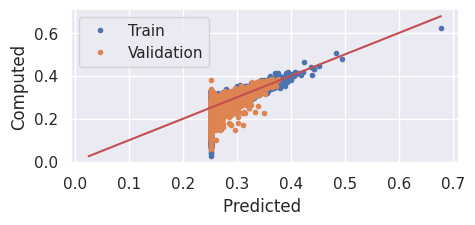

Epoch: 786, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 787, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 788, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 789, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 790, Train MAE: 0.0340, Val MAE: 0.0351


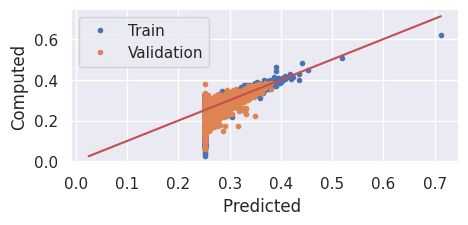

Epoch: 791, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 792, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 793, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 794, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 795, Train MAE: 0.0339, Val MAE: 0.0351


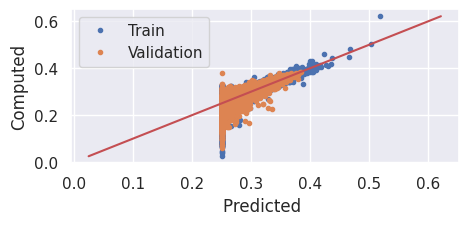

Epoch: 796, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 797, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 798, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 799, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 800, Train MAE: 0.0339, Val MAE: 0.0352


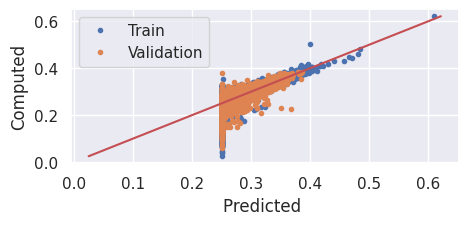

Epoch: 801, Train MAE: 0.0340, Val MAE: 0.0351
Epoch: 802, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 803, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 804, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 805, Train MAE: 0.0340, Val MAE: 0.0351


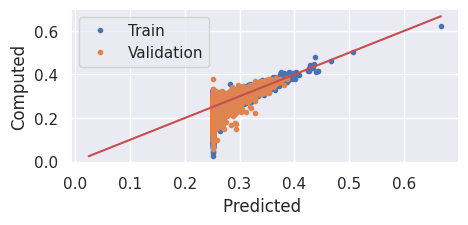

Epoch: 806, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 807, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 808, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 809, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 810, Train MAE: 0.0339, Val MAE: 0.0351


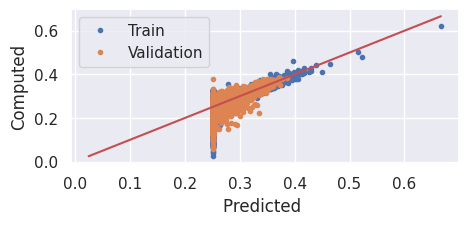

Epoch: 811, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 812, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 813, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 814, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 815, Train MAE: 0.0339, Val MAE: 0.0351


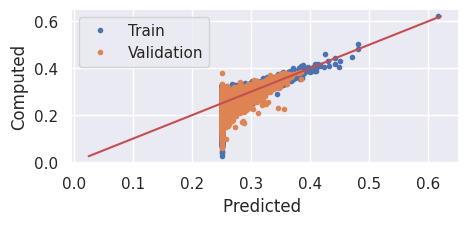

Epoch: 816, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 817, Train MAE: 0.0340, Val MAE: 0.0352
Epoch: 818, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 819, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 820, Train MAE: 0.0339, Val MAE: 0.0351


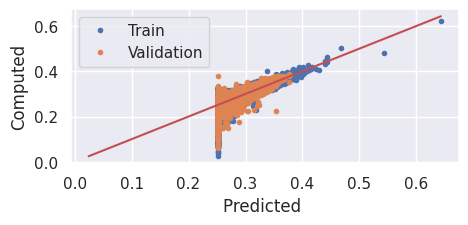

Epoch: 821, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 822, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 823, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 824, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 825, Train MAE: 0.0339, Val MAE: 0.0351


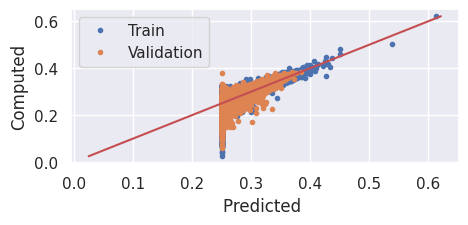

Epoch: 826, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 827, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 828, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 829, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 830, Train MAE: 0.0339, Val MAE: 0.0351


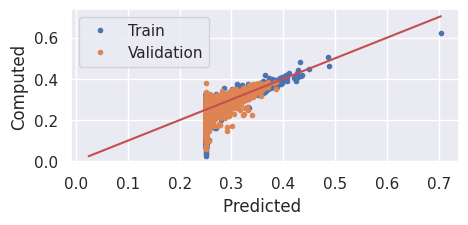

Epoch: 831, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 832, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 833, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 834, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 835, Train MAE: 0.0339, Val MAE: 0.0351


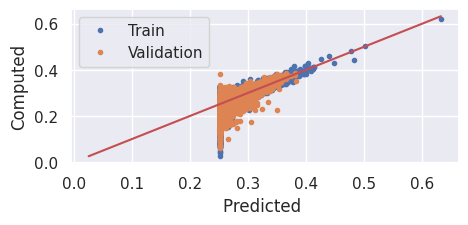

Epoch: 836, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 837, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 838, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 839, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 840, Train MAE: 0.0339, Val MAE: 0.0351


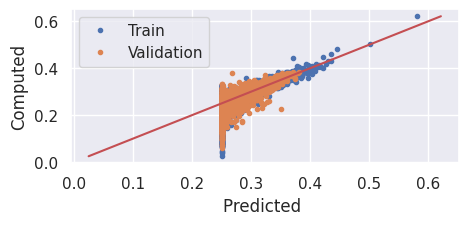

Epoch: 841, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 842, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 843, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 844, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 845, Train MAE: 0.0339, Val MAE: 0.0351


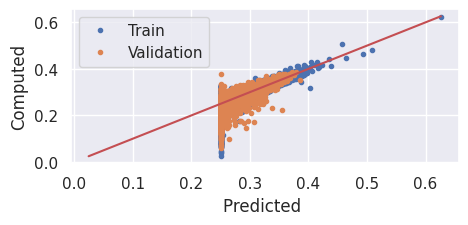

Epoch: 846, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 847, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 848, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 849, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 850, Train MAE: 0.0339, Val MAE: 0.0351


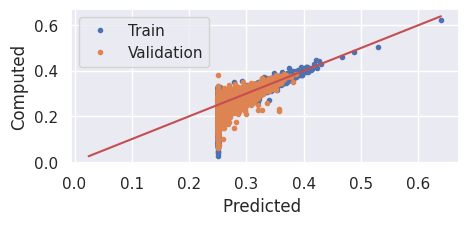

Epoch: 851, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 852, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 853, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 854, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 855, Train MAE: 0.0339, Val MAE: 0.0351


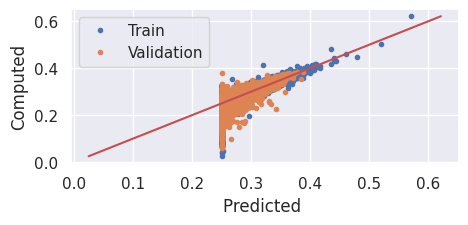

Epoch: 856, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 857, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 858, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 859, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 860, Train MAE: 0.0339, Val MAE: 0.0351


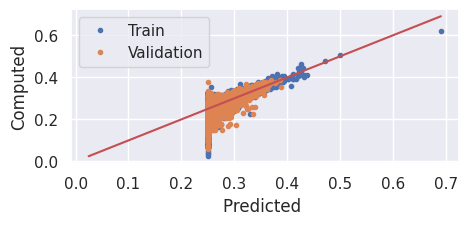

Epoch: 861, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 862, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 863, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 864, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 865, Train MAE: 0.0339, Val MAE: 0.0351


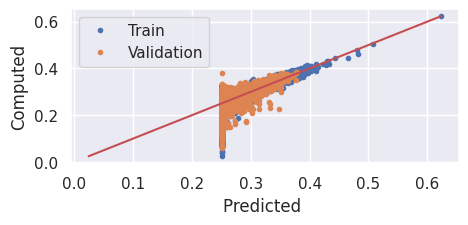

Epoch: 866, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 867, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 868, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 869, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 870, Train MAE: 0.0339, Val MAE: 0.0352


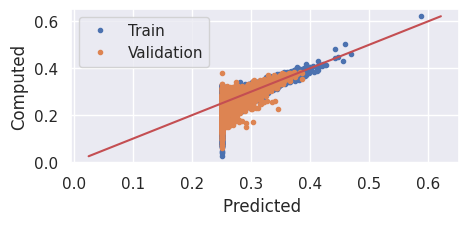

Epoch: 871, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 872, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 873, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 874, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 875, Train MAE: 0.0339, Val MAE: 0.0351


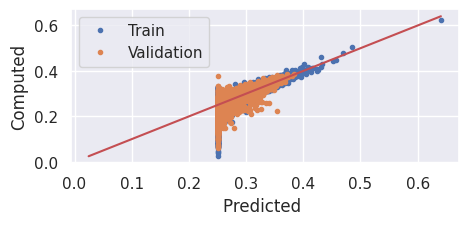

Epoch: 876, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 877, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 878, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 879, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 880, Train MAE: 0.0339, Val MAE: 0.0351


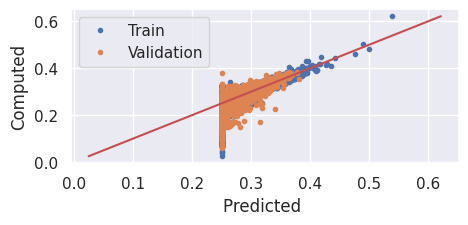

Epoch: 881, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 882, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 883, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 884, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 885, Train MAE: 0.0339, Val MAE: 0.0352


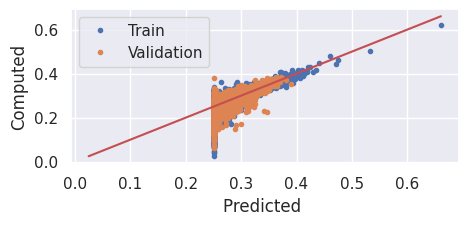

Epoch: 886, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 887, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 888, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 889, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 890, Train MAE: 0.0339, Val MAE: 0.0351


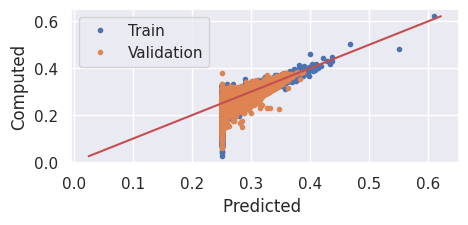

Epoch: 891, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 892, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 893, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 894, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 895, Train MAE: 0.0339, Val MAE: 0.0351


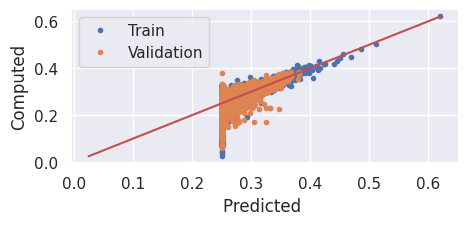

Epoch: 896, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 897, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 898, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 899, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 900, Train MAE: 0.0339, Val MAE: 0.0351


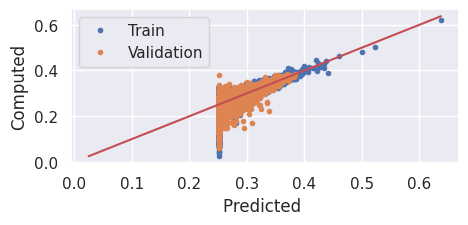

Epoch: 901, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 902, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 903, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 904, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 905, Train MAE: 0.0339, Val MAE: 0.0351


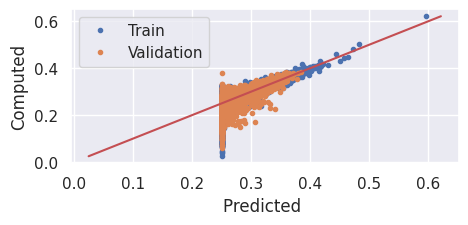

Epoch: 906, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 907, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 908, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 909, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 910, Train MAE: 0.0339, Val MAE: 0.0351


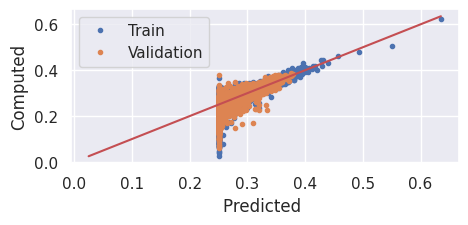

Epoch: 911, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 912, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 913, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 914, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 915, Train MAE: 0.0339, Val MAE: 0.0351


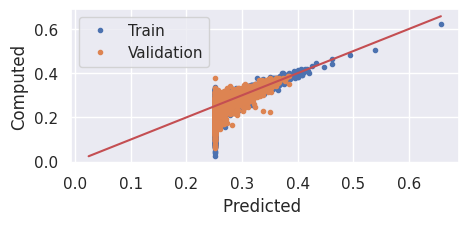

Epoch: 916, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 917, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 918, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 919, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 920, Train MAE: 0.0339, Val MAE: 0.0352


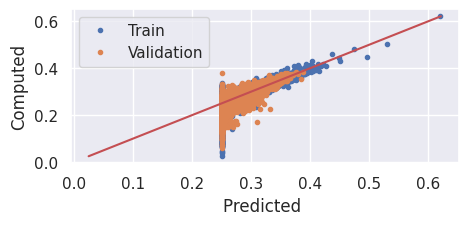

Epoch: 921, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 922, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 923, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 924, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 925, Train MAE: 0.0339, Val MAE: 0.0351


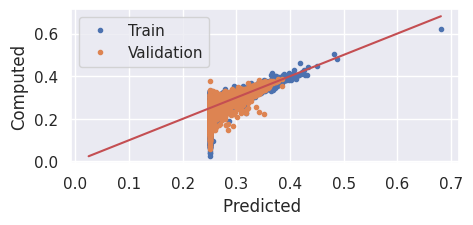

Epoch: 926, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 927, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 928, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 929, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 930, Train MAE: 0.0339, Val MAE: 0.0351


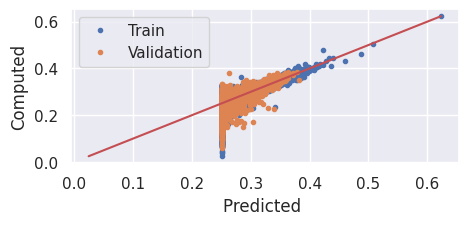

Epoch: 931, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 932, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 933, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 934, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 935, Train MAE: 0.0339, Val MAE: 0.0351


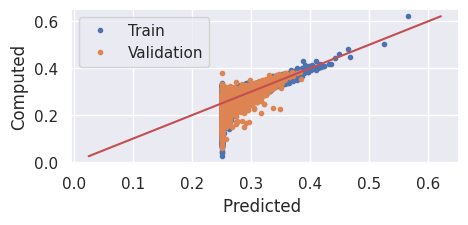

Epoch: 936, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 937, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 938, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 939, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 940, Train MAE: 0.0339, Val MAE: 0.0351


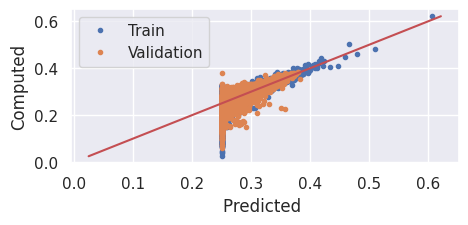

Epoch: 941, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 942, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 943, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 944, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 945, Train MAE: 0.0339, Val MAE: 0.0351


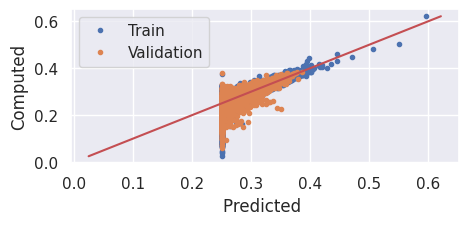

Epoch: 946, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 947, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 948, Train MAE: 0.0339, Val MAE: 0.0353
Epoch: 949, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 950, Train MAE: 0.0339, Val MAE: 0.0351


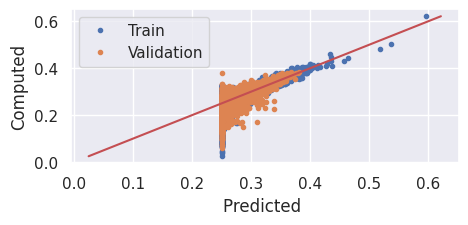

Epoch: 951, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 952, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 953, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 954, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 955, Train MAE: 0.0339, Val MAE: 0.0351


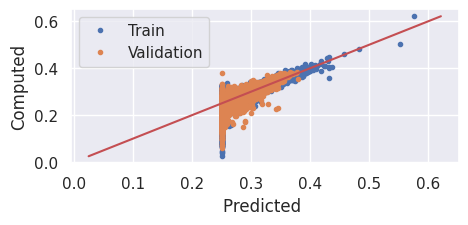

Epoch: 956, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 957, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 958, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 959, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 960, Train MAE: 0.0339, Val MAE: 0.0351


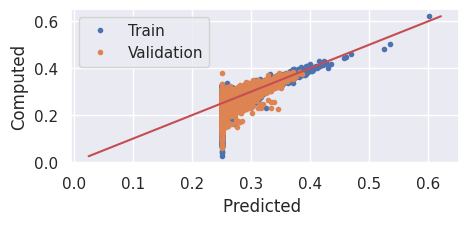

Epoch: 961, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 962, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 963, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 964, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 965, Train MAE: 0.0339, Val MAE: 0.0352


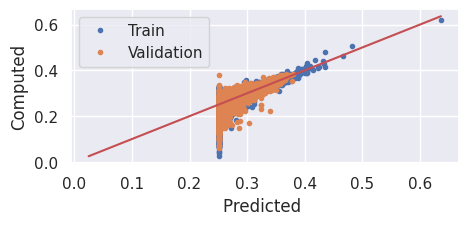

Epoch: 966, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 967, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 968, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 969, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 970, Train MAE: 0.0339, Val MAE: 0.0351


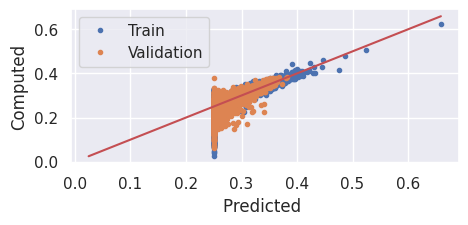

Epoch: 971, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 972, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 973, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 974, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 975, Train MAE: 0.0339, Val MAE: 0.0352


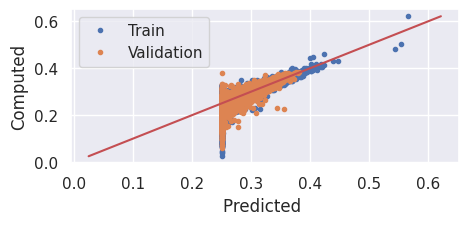

Epoch: 976, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 977, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 978, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 979, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 980, Train MAE: 0.0339, Val MAE: 0.0352


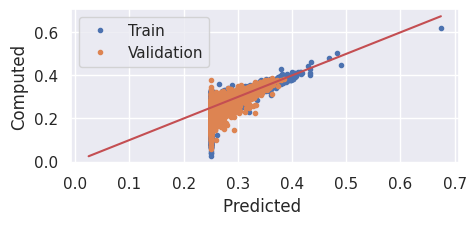

Epoch: 981, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 982, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 983, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 984, Train MAE: 0.0339, Val MAE: 0.0350
Epoch: 985, Train MAE: 0.0339, Val MAE: 0.0351


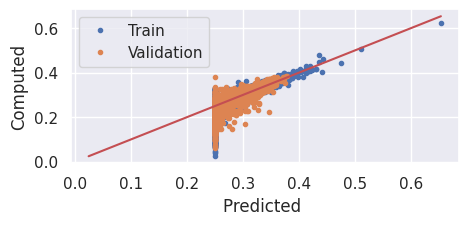

Epoch: 986, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 987, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 988, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 989, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 990, Train MAE: 0.0339, Val MAE: 0.0351


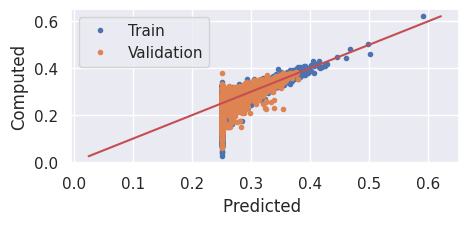

Epoch: 991, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 992, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 993, Train MAE: 0.0339, Val MAE: 0.0352
Epoch: 994, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 995, Train MAE: 0.0339, Val MAE: 0.0351


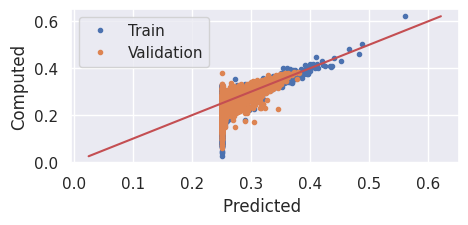

Epoch: 996, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 997, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 998, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 999, Train MAE: 0.0339, Val MAE: 0.0351
Epoch: 1000, Train MAE: 0.0339, Val MAE: 0.0351


In [13]:
# Train the model
for epoch in np.arange(0, 1000):
    train_loss, train_predictions, train_ground_truths = train(model, criterion, train_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device),
                                                               optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(5, 2))
        plt.plot(train_predictions, train_ground_truths, '.', label='Train')
        plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
        plt.xlabel(r'Predicted ')
        plt.ylabel(r'Computed')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Log information in wandb
    wandb.log({
        'Epoch':      epoch,
        'Train Loss': train_loss,
        'Val Loss':   val_loss})

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

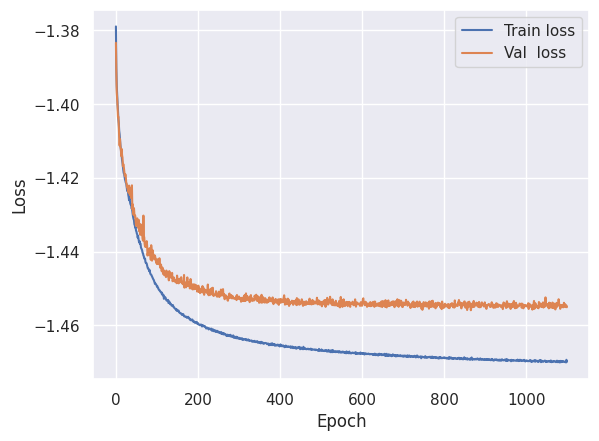

In [14]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
#plt.savefig(f'example/loss-function.eps', dpi=50, bbox_inches='tight')
plt.show()

# Visualization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


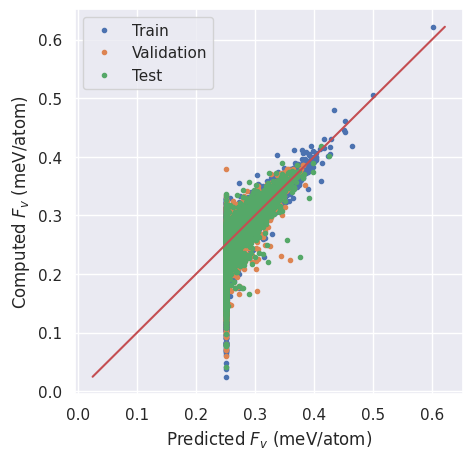

Train MAE: 0.0340, Val MAE: 0.0351, Test MAE: 0.0350


In [15]:
# Load Graph Neural Network model
model.load_state_dict(torch.load(f'{target_folder}/model.pt'))
model.eval()

# Train the model
for epoch in np.arange(0, 1):
    train_loss, train_predictions, train_ground_truths = train(model, criterion, train_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device),
                                                               optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device))
    test_loss,  test_predictions,  test_ground_truths  =  test(model, criterion, test_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device))
    
    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()
    test_loss  = np.sqrt(test_loss)  * target_factor.item()
    
    stack = np.concatenate([train_predictions, train_ground_truths,
                            val_predictions,   val_ground_truths,
                            test_predictions,  test_ground_truths])

    _min_ = np.min(stack)
    _max_ = np.max(stack)

    plt.figure(figsize=(5, 5))
    plt.plot(train_predictions, train_ground_truths, '.', label='Train')
    plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
    plt.plot(test_predictions,  test_ground_truths,  '.', label='Test')
    plt.xlabel(r'Predicted $F_v$ (meV/atom)')
    plt.ylabel(r'Computed $F_v$ (meV/atom)')
    plt.plot([_min_, _max_], [_min_, _max_], '-r')
    plt.legend(loc='best')
    plt.savefig(f'{target_folder}/GCNN-training.eps', dpi=dpi, bbox_inches='tight')
    plt.show()

    print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')